# SB4 — BO-only EI vs KG under noise

In [1]:
import os, sys, time, json, glob
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Image, Markdown, HTML

# Ensure local modules are importable
ROOT = Path("/mnt/data").resolve()
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

import main  # uses /mnt/data/main.py
from evaluator import (
    load_logs, aggregate_regret, plot_regret_curves, add_normalized_regret,
    aggregate_regret_norm, plot_regret_norm_curves, plot_box_regret_at_T,
    plot_box_regret_norm_at_T, plot_box_best_value_at_T, plot_ybest_curves,
    rank_by_group, winrate_by_group, plot_rank_heatmap, plot_winrate_heatmap,
    save_rank_tables, save_tables, export_best_at_T_table,
    save_best_at_T_tables_as_png, render_boxplot_side_tables, export_auc_table_from_agg
)  # uses /mnt/data/evaluator.py

def find_latest_results(exp_name: str) -> Path:
    root = Path("results")
    if not root.exists():
        raise FileNotFoundError("No results/ folder yet.")
    cands = [p for p in root.glob(f"*_{exp_name}") if p.is_dir()]
    if not cands:
        # fallback: any folder containing exp_name
        cands = [p for p in root.glob("*_*") if exp_name in p.name]
    if not cands:
        raise FileNotFoundError(f"No results subfolder matching: {exp_name}")
    return max(cands, key=lambda p: p.stat().st_mtime)

def show_pngs(paths, width=820):
    for p in paths:
        p = Path(p)
        if p.exists():
            display(Image(filename=str(p), width=width))

def show_all_core_plots(outdir: Path):
    # Display the plots main.py already created when PLOT_IN_MAIN=True
    plots = outdir / "plots"
    # groups = [
    #     "regret_curves", "regret_curves_obs", "regret_norm_curves",
    #     "regret", "regret_obs", "regret_norm", "best_value", "heatmaps"
    # ]
    groups = [
        "regret_curves", "regret_norm_curves",
        "regret", "regret_norm", "best_value", "heatmaps"
    ]
    all_imgs = []
    for g in groups:
        d = plots / g
        if d.exists():
            all_imgs += sorted(d.glob("*.png"))
    if all_imgs:
        print(f"Showing {len(all_imgs)} plot images ...")
        show_pngs(all_imgs)

    # Also show the small per-boxplot side tables (PNG) if present
    table_pngs = sorted((outdir/"plots").rglob("*_table.png"))
    if table_pngs:
        print(f"Showing {len(table_pngs)} boxplot side-table PNGs ...")
        show_pngs(table_pngs, width=640)

    # And global 'best_at_T' PNG tables
    global_tables = sorted((outdir/"tables").glob("best_at_T_*.png"))
    if global_tables:
        print("Global Best@T tables:")
        show_pngs(global_tables, width=720)

def show_core_dataframes(outdir: Path):
    # Load unified logs
    df = load_logs(outdir)
    print("all_runs.csv shape:", df.shape)
    # Final rows per run for boxplots
    keys = ["problem","method","seed","budget"]
    if "noise_pct" in df.columns:
        keys.append("noise_pct")
    dff = df.sort_values("iter").groupby(keys, as_index=False).tail(1)
    display(Markdown("**Final rows per run (for boxplots):**"))
    display(dff.head(20))

    # Aggregates for curves (true & observed regret)
    agg_true = aggregate_regret(df, use_observed=False)
    display(Markdown("**Aggregate (true regret) for curves:**"))
    display(agg_true.head(20))
    # agg_obs = aggregate_regret(df, use_observed=True)
    # display(Markdown("**Aggregate (observed regret) for curves:**"))
    # display(agg_obs.head(20))

    # Normalized regret
    dfn = add_normalized_regret(df.copy())
    if "regret_norm" in dfn.columns:
        aggn = aggregate_regret_norm(dfn)
        display(Markdown("**Aggregate (normalized regret) for curves:**"))
        display(aggn.head(20))

def run_and_collect(exp_name: str):
    # main.main() uses current module-level config values set below.
    print("Launching main.main() ...")
    main.main()
    outdir = find_latest_results(exp_name)

    # Recompute aggregates and export AUC tables
    from evaluator import aggregate_regret, aggregate_regret_norm, add_normalized_regret, export_auc_table_from_agg
    df_all = load_logs(outdir)

    agg_true = aggregate_regret(df_all, use_observed=False)
    export_auc_table_from_agg(agg_true, outdir, label="true")

    # agg_obs = aggregate_regret(df_all, use_observed=True)
    # export_auc_table_from_agg(agg_obs, outdir, label="obs")

    dfn = add_normalized_regret(df_all.copy())
    if "regret_norm" in dfn.columns:
        aggn = aggregate_regret_norm(dfn)
        export_auc_table_from_agg(aggn, outdir, label="norm")

    print("Artifacts written to:", outdir)
    # Ensure all table PNGs exist (best@T + per-boxplot)
    try:
        save_best_at_T_tables_as_png(outdir, decimals=3)
    except Exception as e:
        print("[warn] save_best_at_T_tables_as_png:", e)
    try:
        render_boxplot_side_tables(outdir, decimals=3)
    except Exception as e:
        print("[warn] render_boxplot_side_tables:", e)
    return outdir


In [2]:
# --- CONFIG --------------------------------------------------------------
main.EXP_NAME      = 'SB4_BO_EI_vs_KG_noise'
main.PROBLEMS      = ['Branin']
main.METHODS       = ['BO_EI', 'BO_KG']
main.BUDGETS       = [50]
main.SEEDS         = list(range(40))
main.NOISE_PCTS    = [0.0, 0.2, 0.5]
main.INIT_FACTOR   = 2.0
main.PLOT_IN_MAIN  = True
main.GENERATE_SAMPLES   = False
main.FINAL_SAMPLES_AT_T = True
main.K_EVERY            = 1


# ! Don't run following code cell again --> would lead to multiple hundred subbenchmark runs!

Launching main.main() ...
[run] Branin | BO_EI | seed=0 | T=50 | noise=0.00
[run] Branin | BO_EI | seed=0 | T=50 | noise=0.20
[run] Branin | BO_EI | seed=0 | T=50 | noise=0.50
[run] Branin | BO_EI | seed=1 | T=50 | noise=0.00
[run] Branin | BO_EI | seed=1 | T=50 | noise=0.20
[run] Branin | BO_EI | seed=1 | T=50 | noise=0.50
[run] Branin | BO_EI | seed=2 | T=50 | noise=0.00
[run] Branin | BO_EI | seed=2 | T=50 | noise=0.20
[run] Branin | BO_EI | seed=2 | T=50 | noise=0.50
[run] Branin | BO_EI | seed=3 | T=50 | noise=0.00
[run] Branin | BO_EI | seed=3 | T=50 | noise=0.20
[run] Branin | BO_EI | seed=3 | T=50 | noise=0.50
[run] Branin | BO_EI | seed=4 | T=50 | noise=0.00
[run] Branin | BO_EI | seed=4 | T=50 | noise=0.20
[run] Branin | BO_EI | seed=4 | T=50 | noise=0.50
[run] Branin | BO_EI | seed=5 | T=50 | noise=0.00
[run] Branin | BO_EI | seed=5 | T=50 | noise=0.20
[run] Branin | BO_EI | seed=5 | T=50 | noise=0.50
[run] Branin | BO_EI | seed=6 | T=50 | noise=0.00
[run] Branin | BO_EI | s

c:\Users\marti\OneDrive\Documents\Bildung\Studium\Data_Science\IU-Data_Science\Abschlussarbeit\Code_Pipeline\Final-Sub-Benchmarks\evaluator.py:1058: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  plt.savefig(out / fname, dpi=150, bbox_inches="tight")
c:\Users\marti\OneDrive\Documents\Bildung\Studium\Data_Science\IU-Data_Science\Abschlussarbeit\Code_Pipeline\Final-Sub-Benchmarks\evaluator.py:1058: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  plt.savefig(out / fname, dpi=150, bbox_inches="tight")
c:\Users\marti\OneDrive\Documents\Bildung\Studium\Data_Science\IU-Data_Science\Abschlussarbeit\Code_Pipeline\Final-Sub-Benchmarks\evaluator.py:2125: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
c:\Users\marti\OneDrive\Documents\Bildung\Studium\Data_Science\IU-Data_Science\Abschlussarbe

Table PNGs: {'true': 'results\\20251027_224019_SB4_BO_EI_vs_KG_noise\\tables\\best_at_T_by_seed_method_true.png', 'obs': 'results\\20251027_224019_SB4_BO_EI_vs_KG_noise\\tables\\best_at_T_by_seed_method_obs.png', 'norm': 'results\\20251027_224019_SB4_BO_EI_vs_KG_noise\\tables\\best_at_T_by_seed_method_norm.png'}
[warn] render_boxplot_side_tables failed: name '_df_apply_elementwise' is not defined
Report: results\20251027_224019_SB4_BO_EI_vs_KG_noise\benchmark_report.html
[debug] all_runs shape: (12000, 21), columns: ['best_so_far', 'best_so_far_obs', 'budget', 'dim', 'exp_name', 'init_factor', 'iter', 'method', 'noise_pct', 'noise_seed', 'problem', 'regret', 'regret_obs', 'seed', 'sigma_noise', 'time_s', 'x', 'x_uv', 'x_xy', 'y', 'y_noisy']
Artifacts written to: results\20251027_224019_SB4_BO_EI_vs_KG_noise


c:\Users\marti\OneDrive\Documents\Bildung\Studium\Data_Science\IU-Data_Science\Abschlussarbeit\Code_Pipeline\Final-Sub-Benchmarks\evaluator.py:1907: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
c:\Users\marti\OneDrive\Documents\Bildung\Studium\Data_Science\IU-Data_Science\Abschlussarbeit\Code_Pipeline\Final-Sub-Benchmarks\evaluator.py:1907: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


Artifacts written to: results\20251027_224019_SB4_BO_EI_vs_KG_noise


c:\Users\marti\OneDrive\Documents\Bildung\Studium\Data_Science\IU-Data_Science\Abschlussarbeit\Code_Pipeline\Final-Sub-Benchmarks\evaluator.py:2125: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
c:\Users\marti\OneDrive\Documents\Bildung\Studium\Data_Science\IU-Data_Science\Abschlussarbeit\Code_Pipeline\Final-Sub-Benchmarks\evaluator.py:2125: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
c:\Users\marti\OneDrive\Documents\Bildung\Studium\Data_Science\IU-Data_Science\Abschlussarbeit\Code_Pipeline\Final-Sub-Benchmarks\evaluator.py:2125: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


[warn] render_boxplot_side_tables: name '_df_apply_elementwise' is not defined
Showing 30 plot images ...


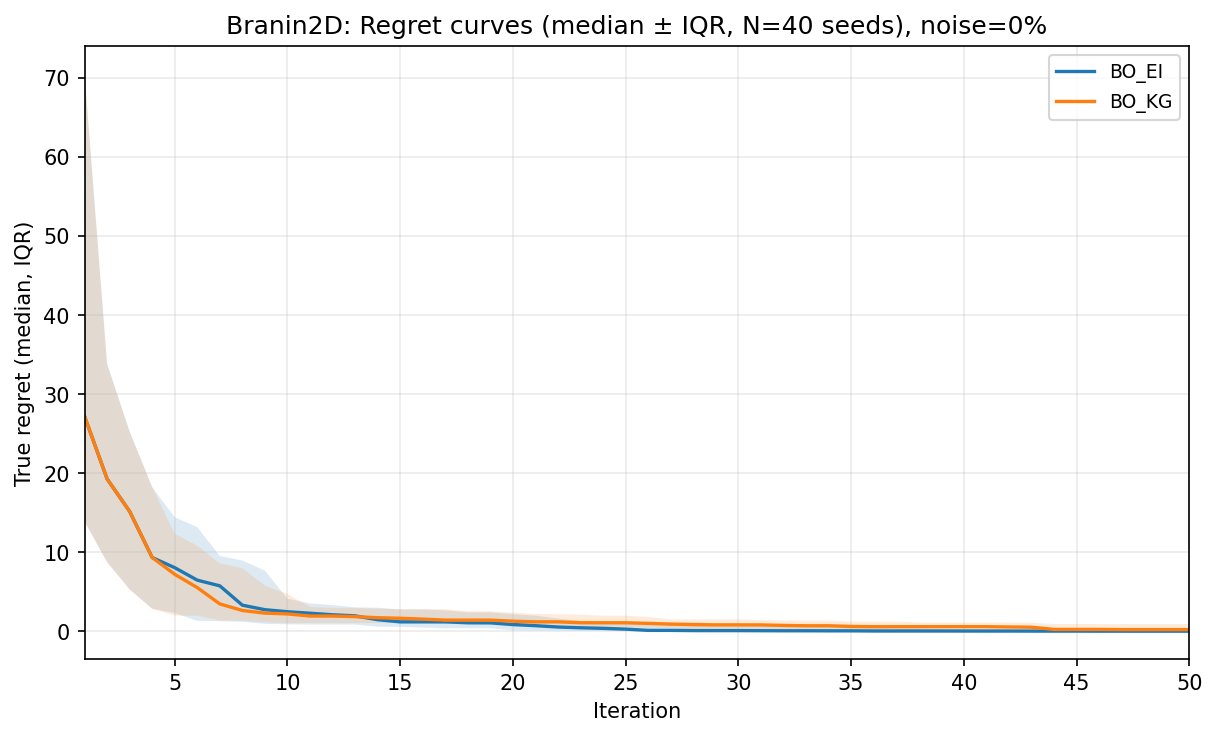

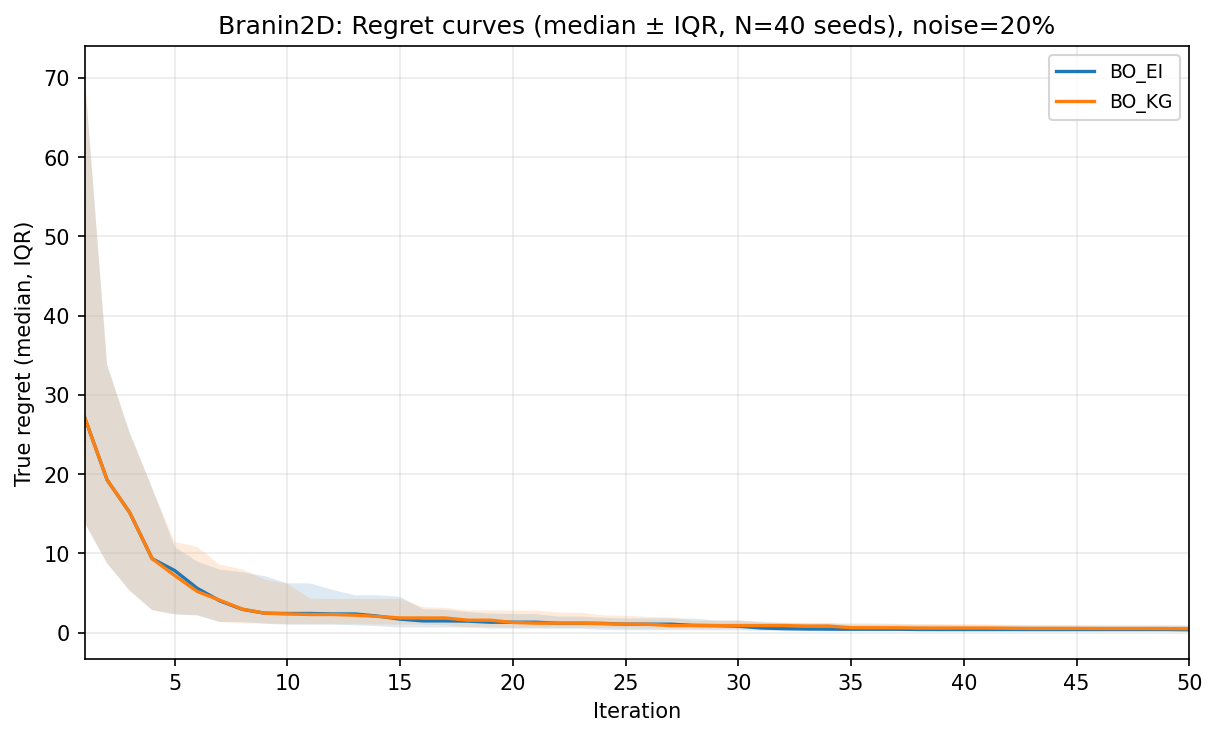

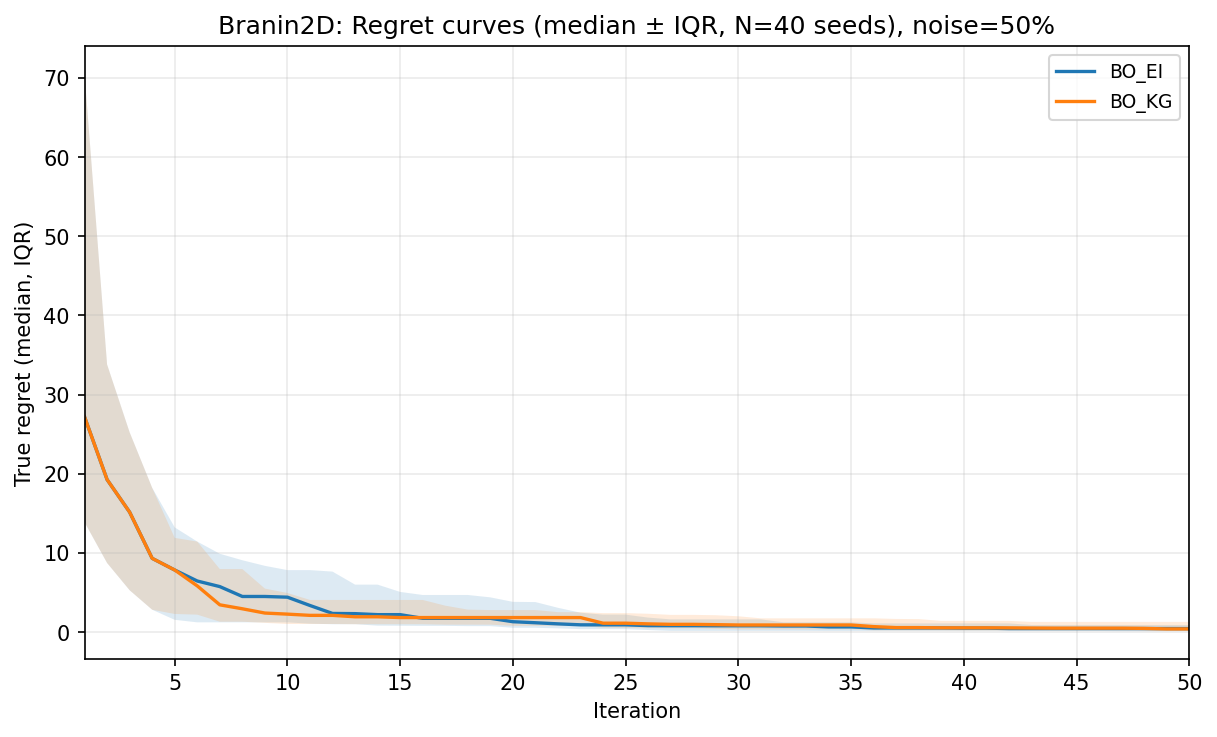

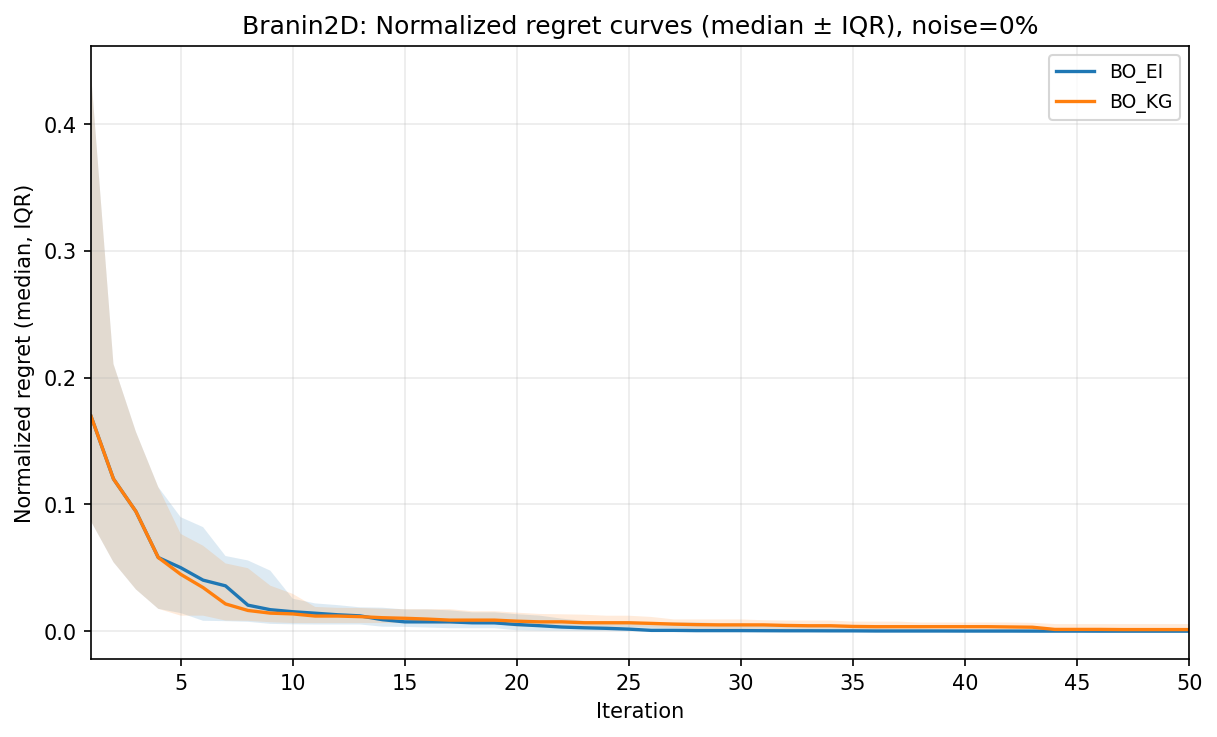

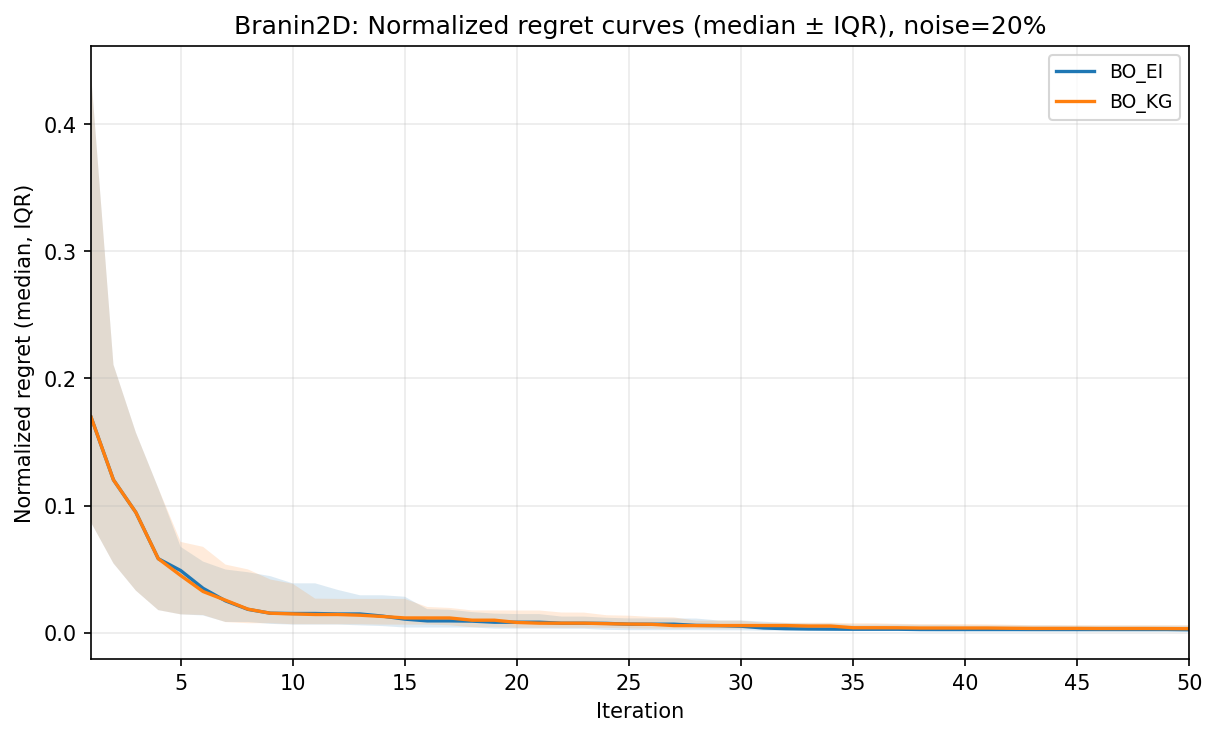

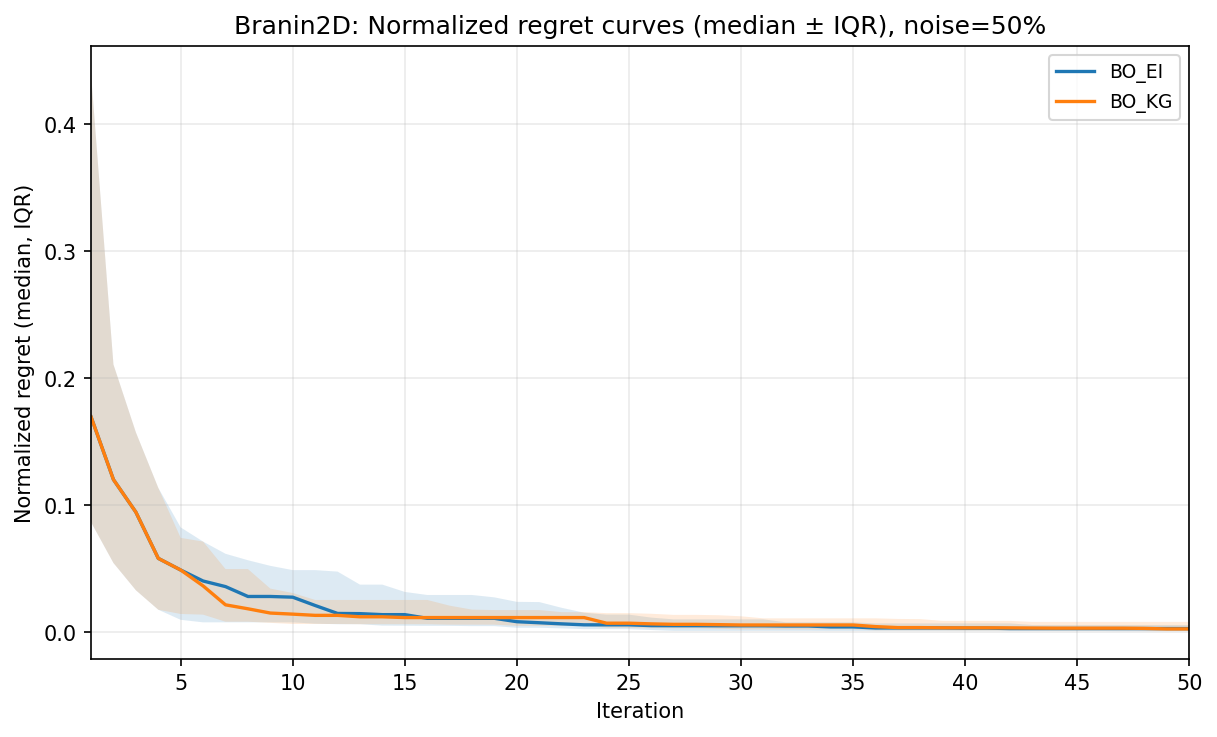

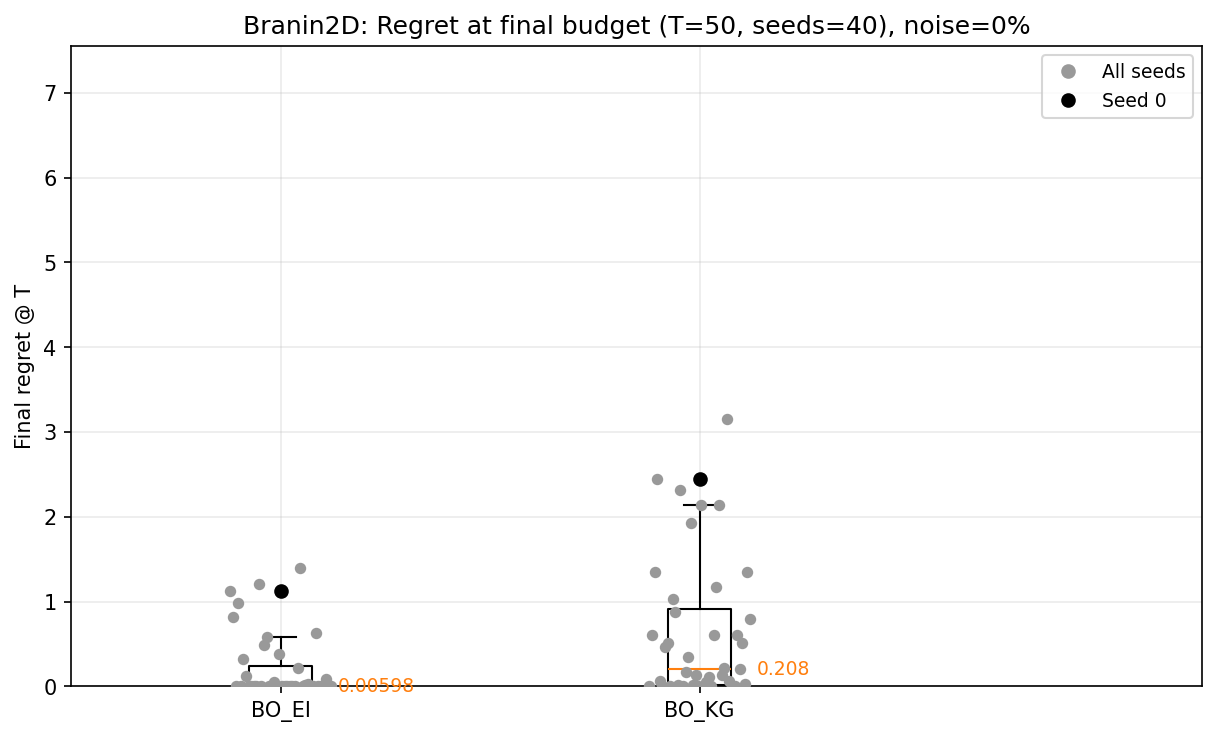

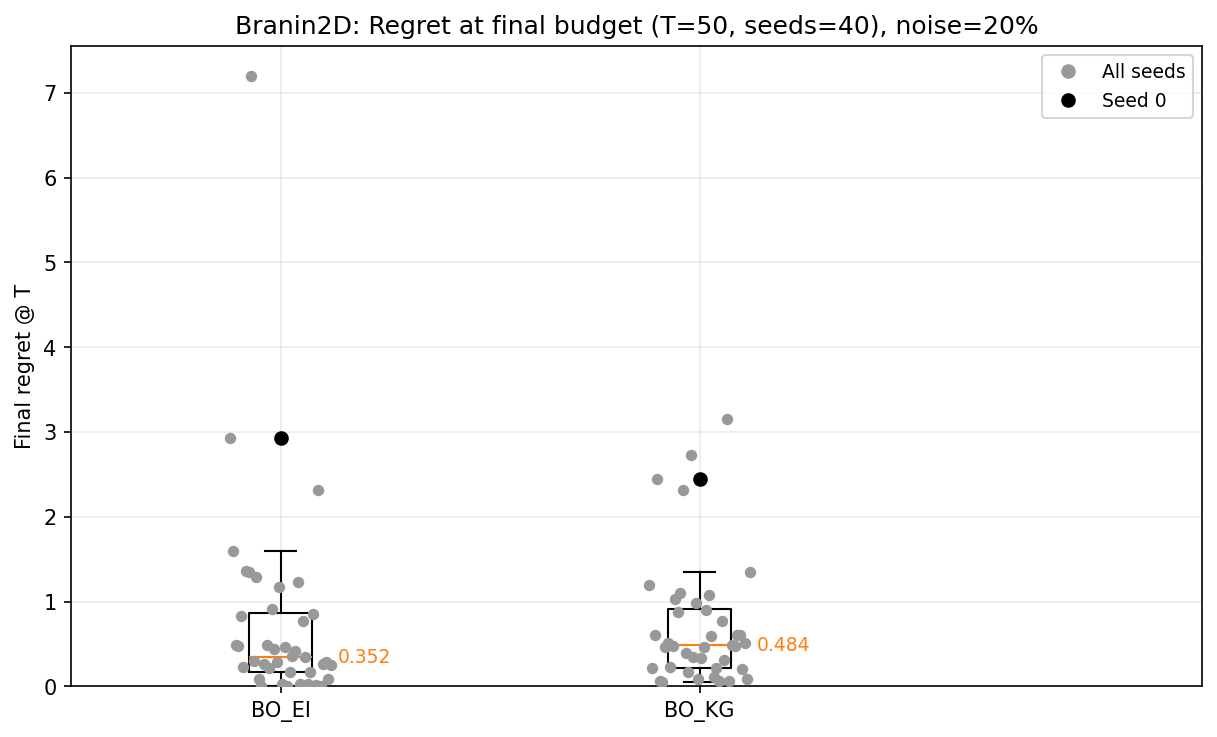

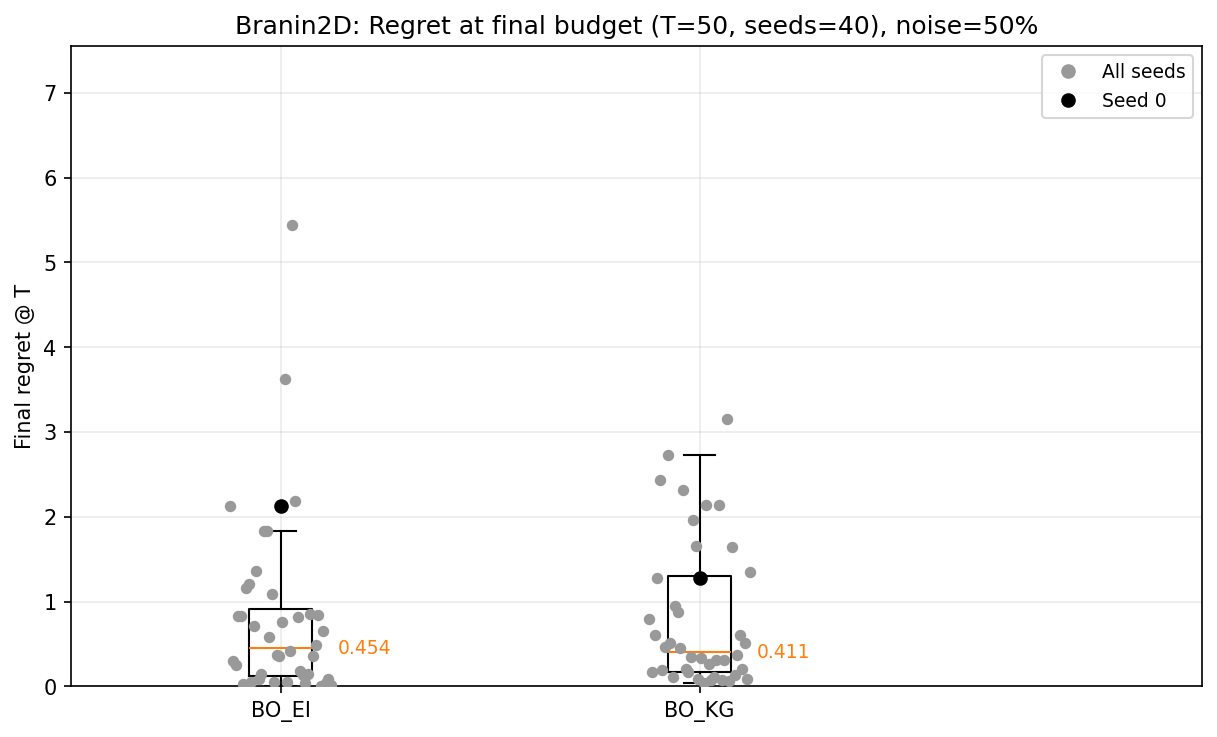

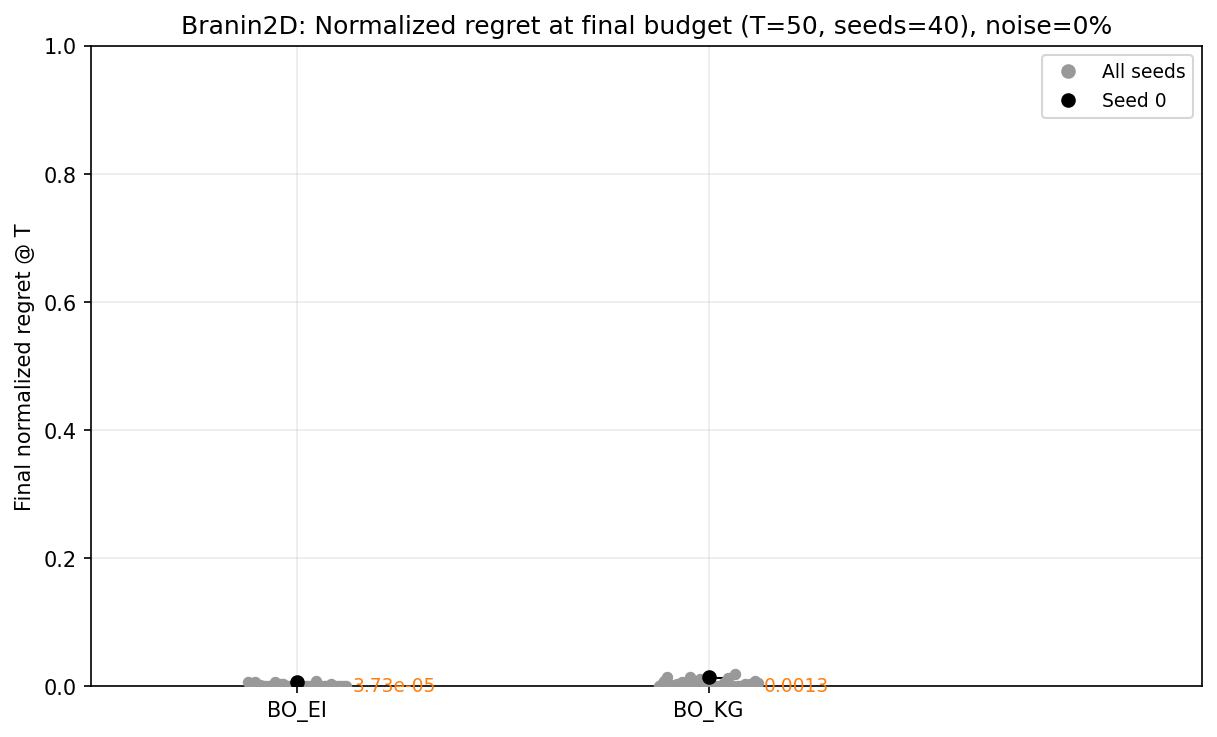

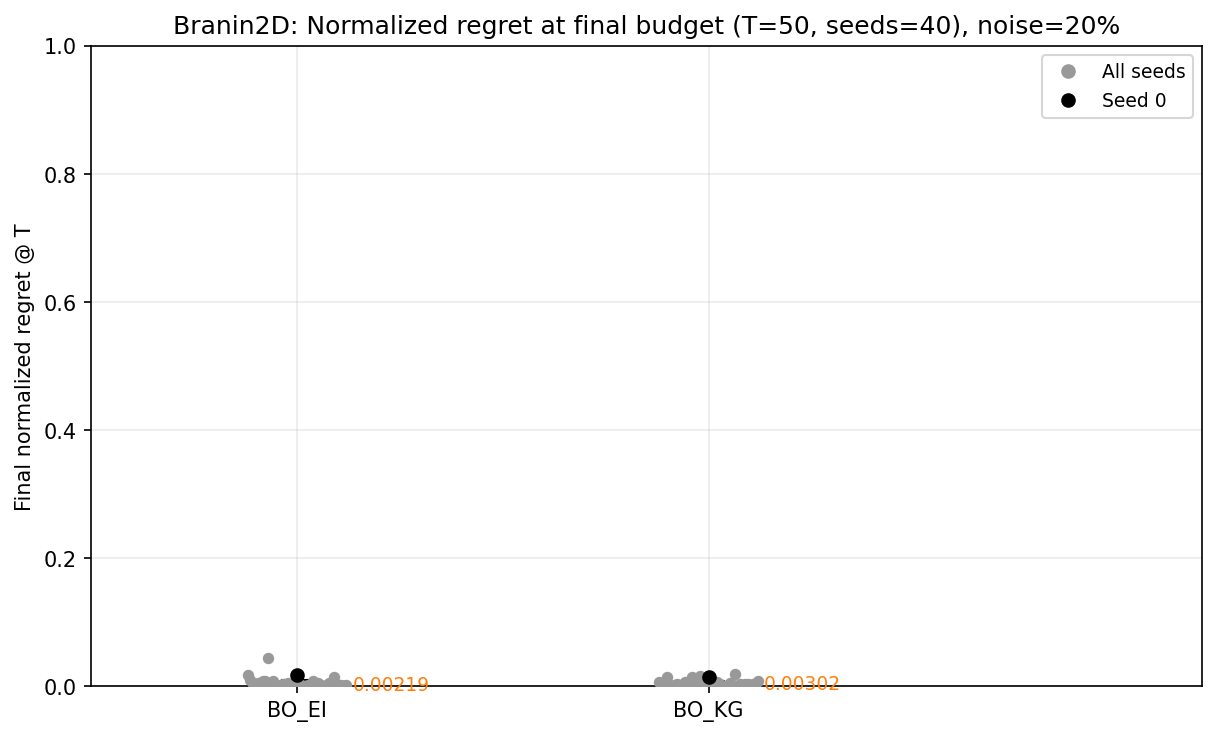

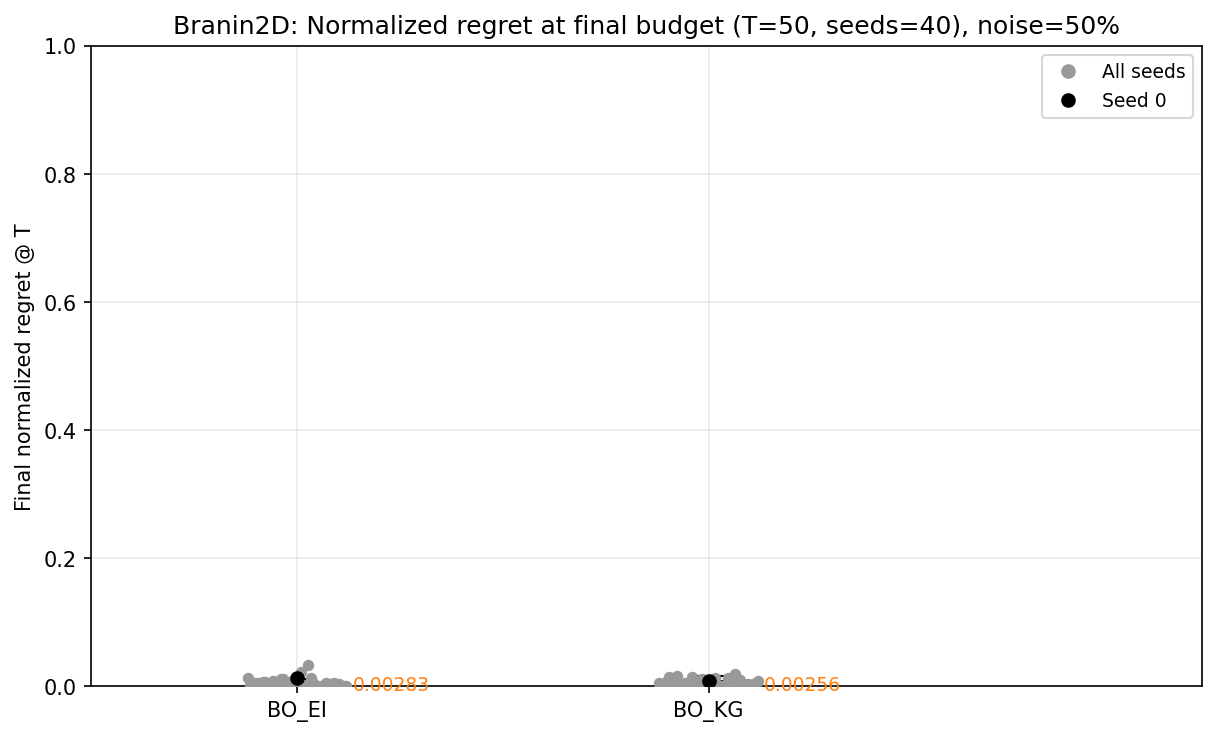

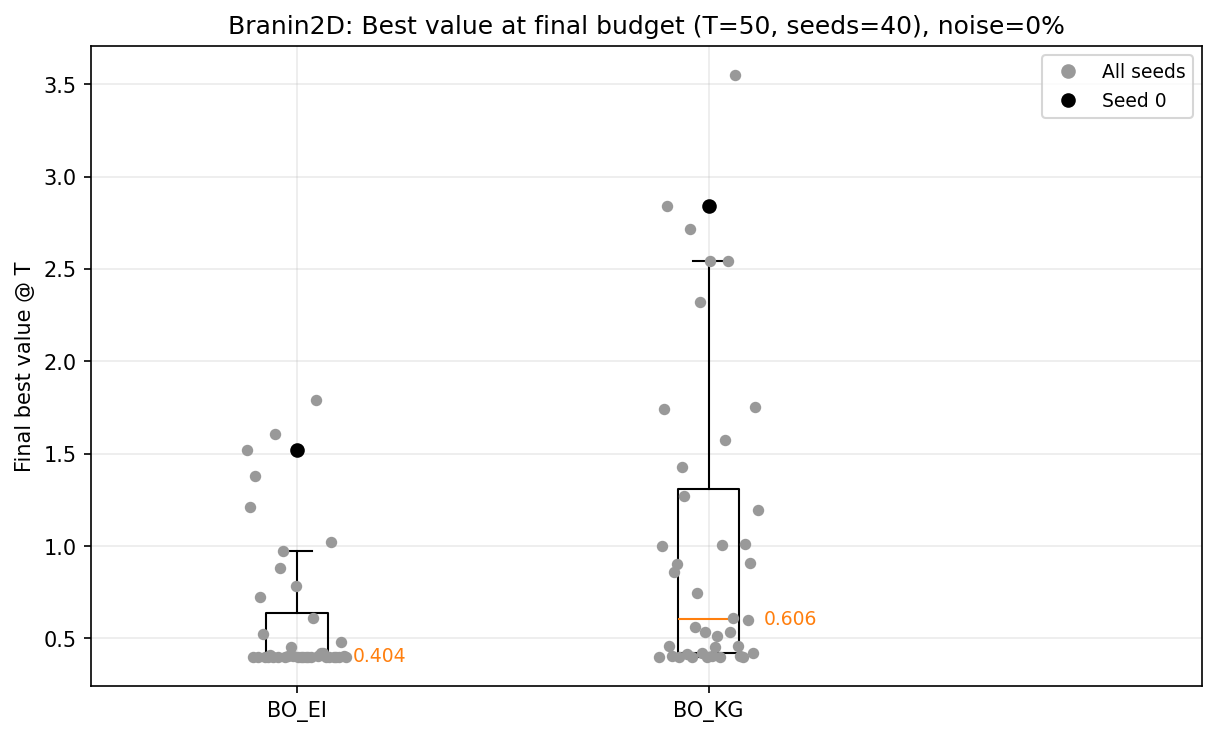

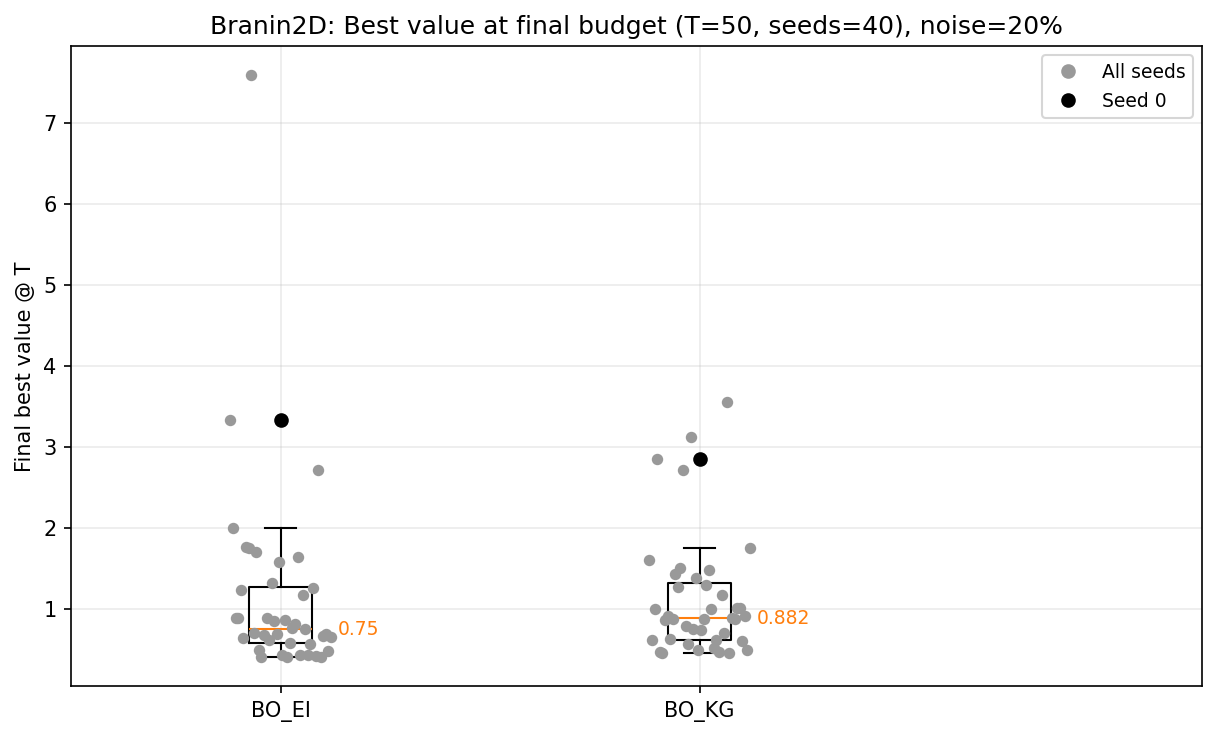

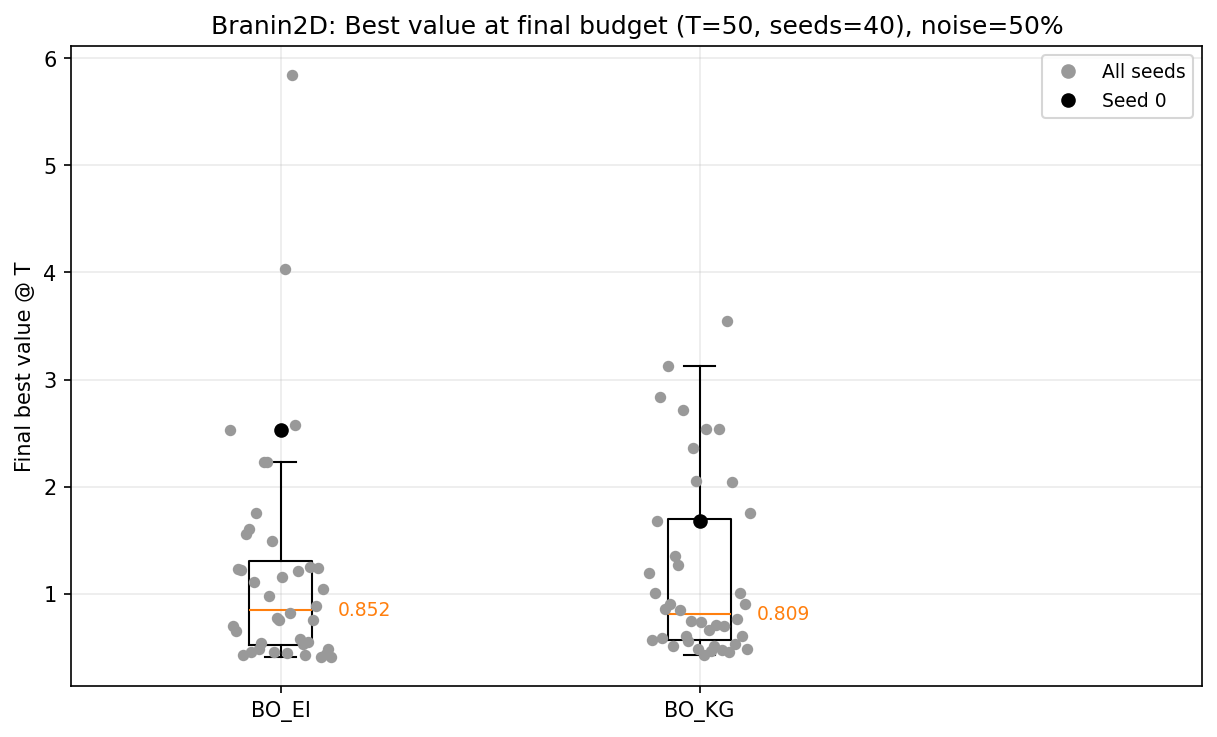

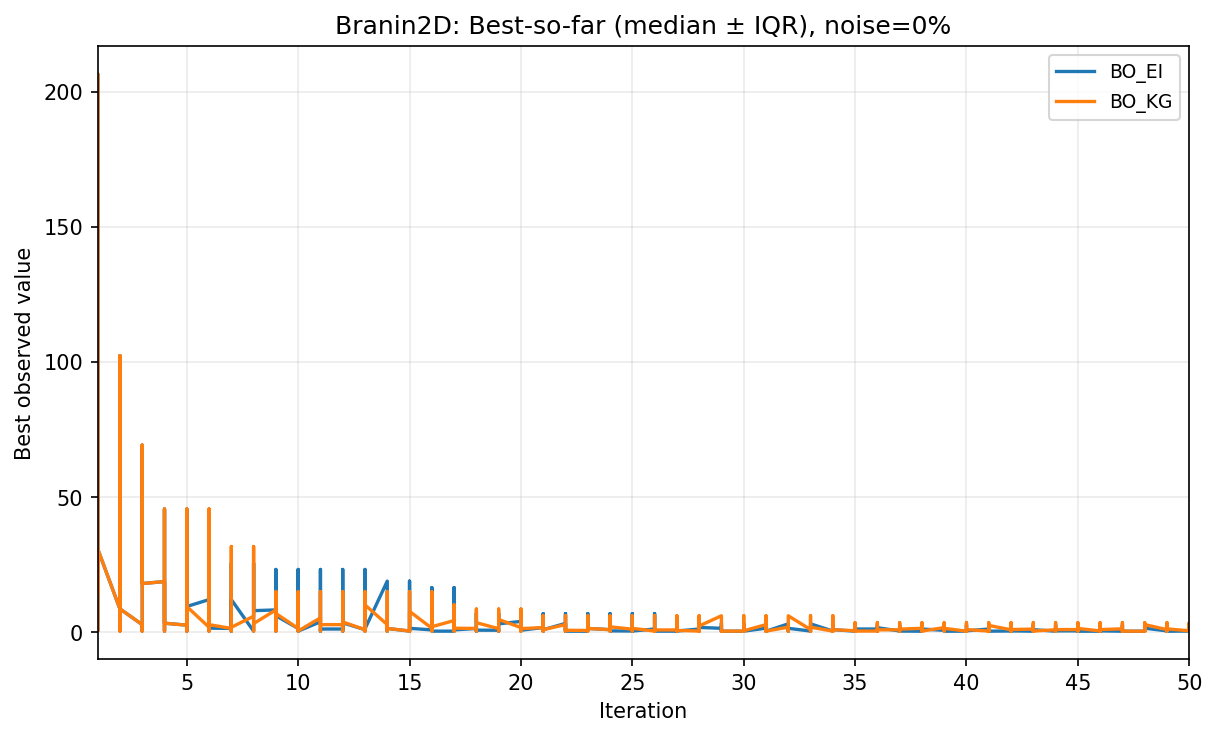

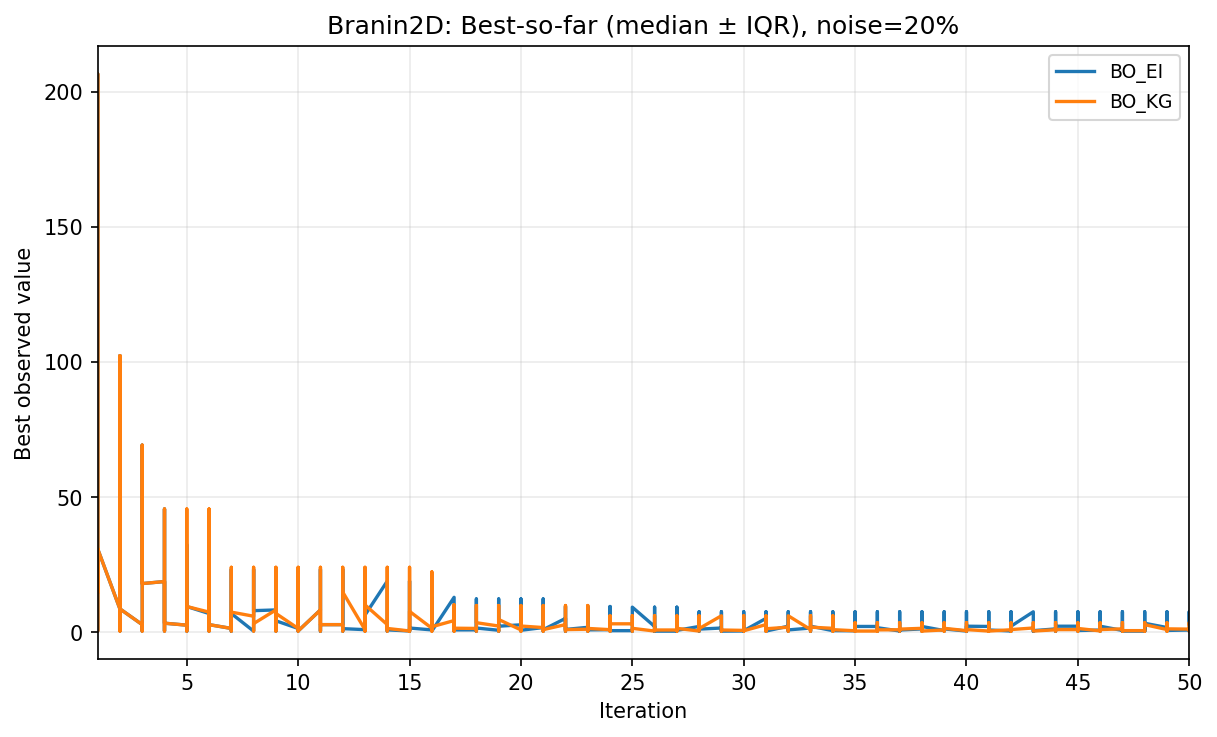

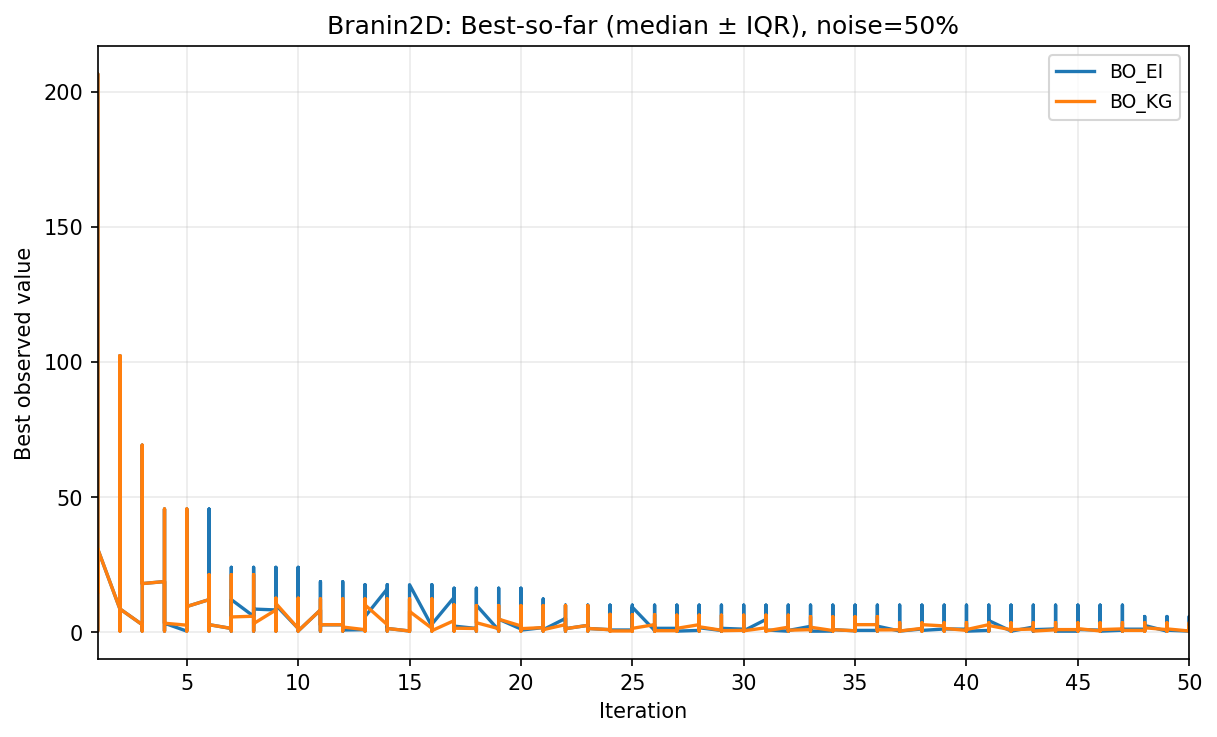

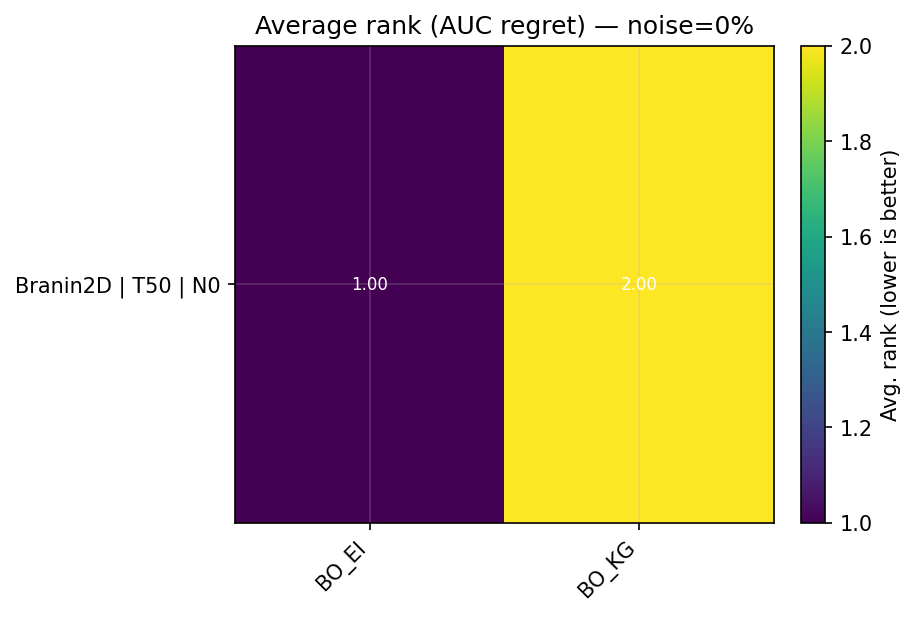

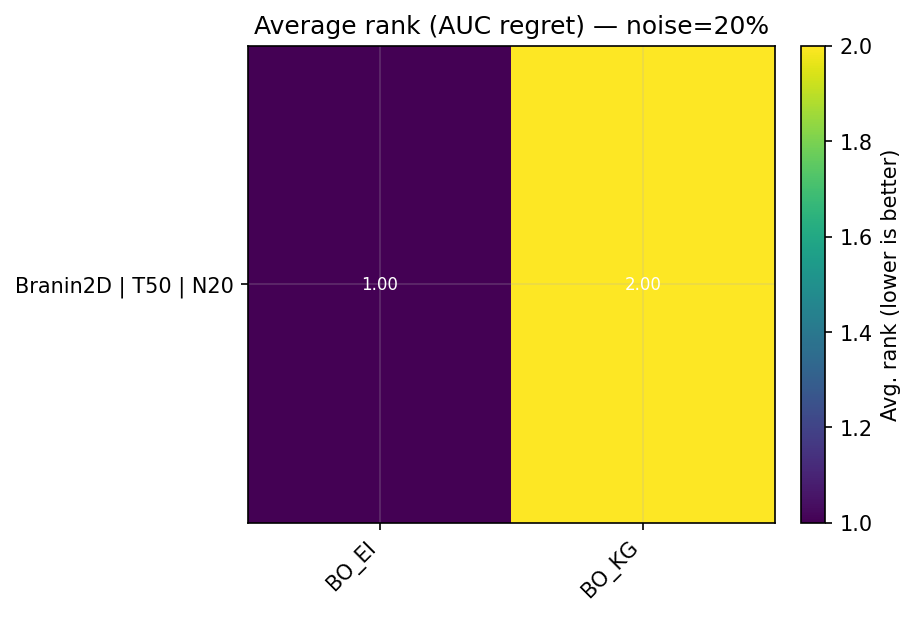

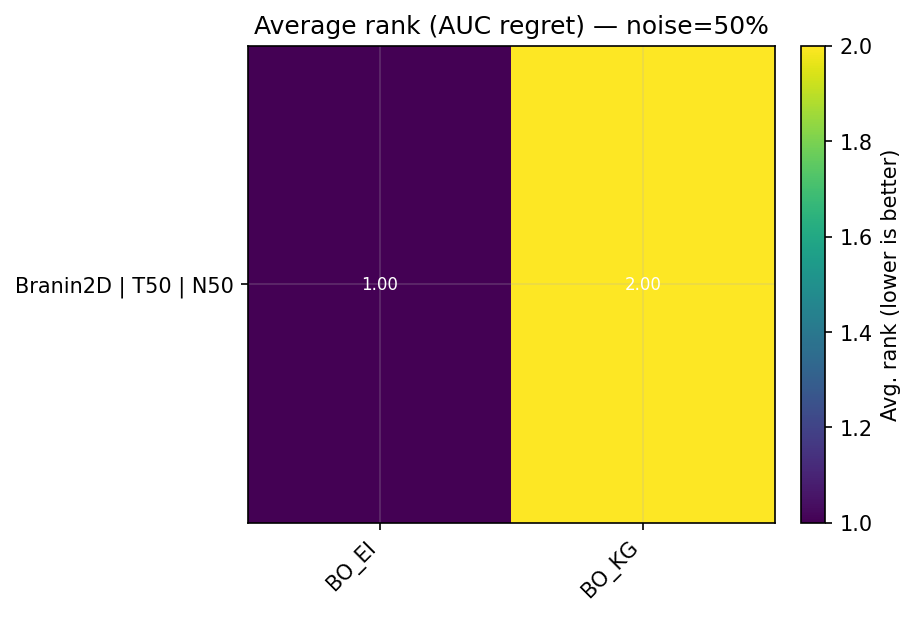

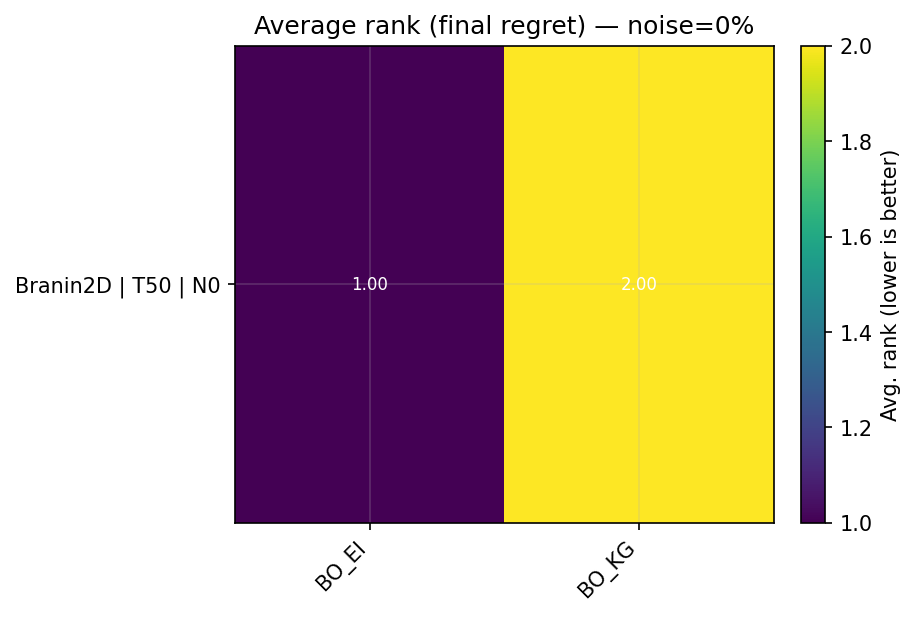

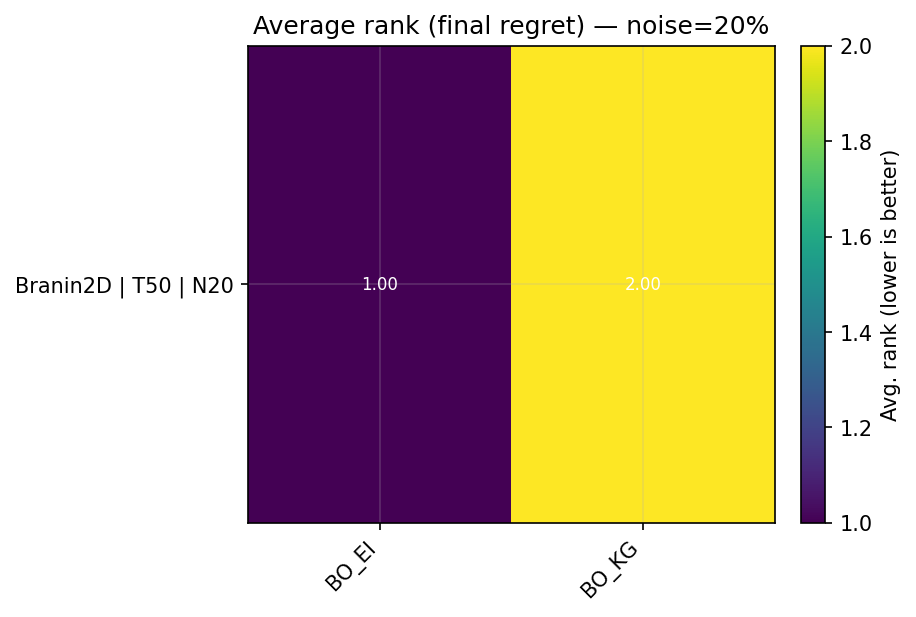

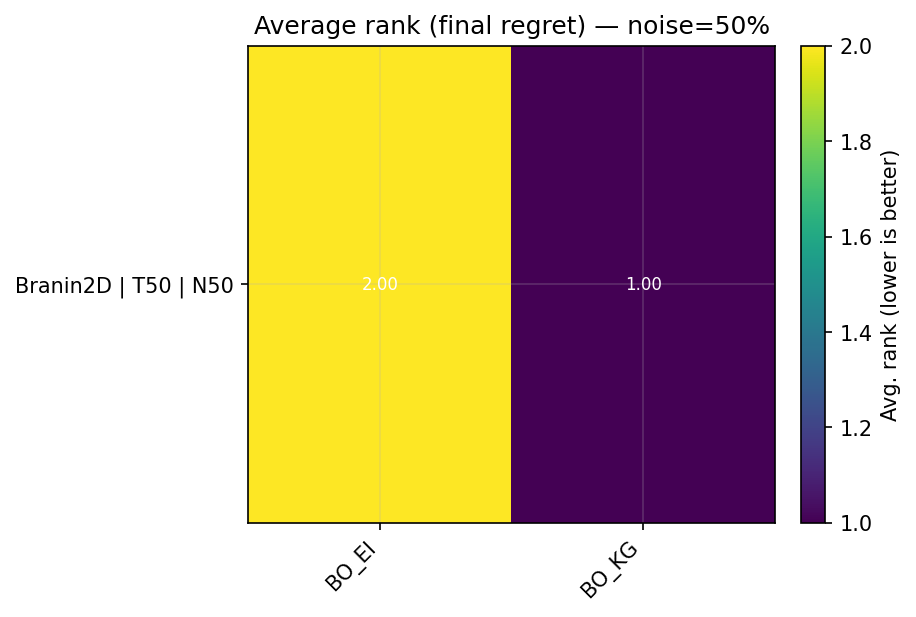

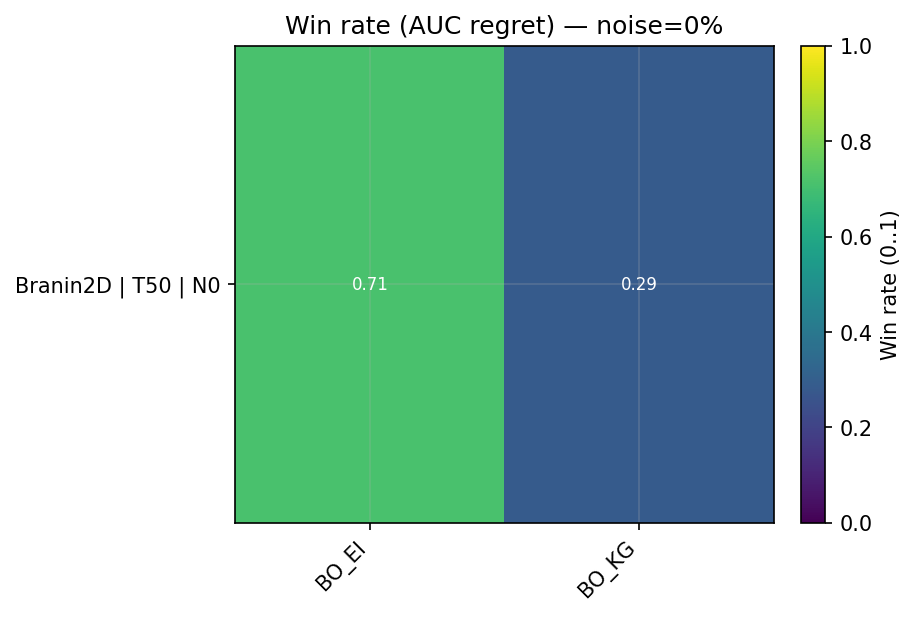

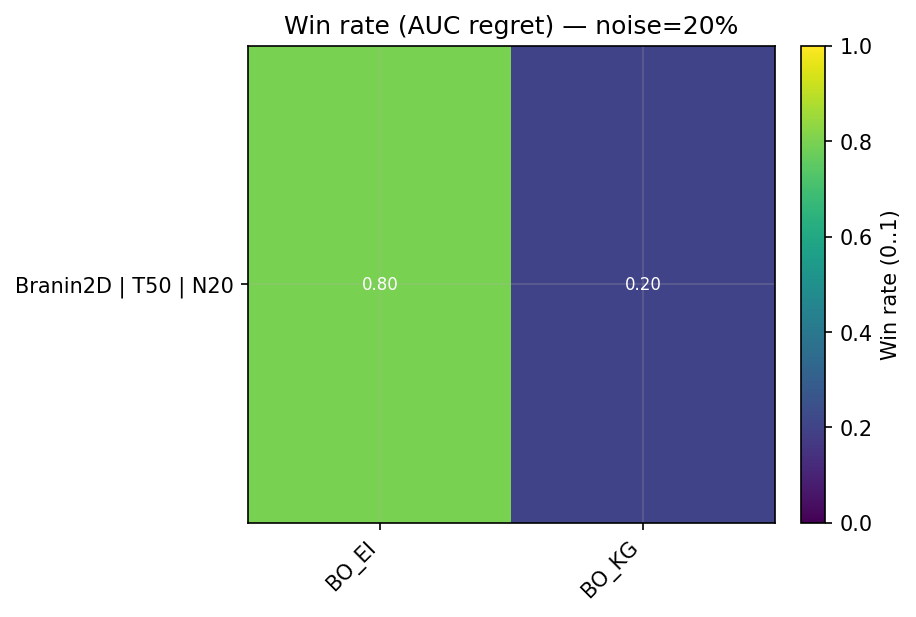

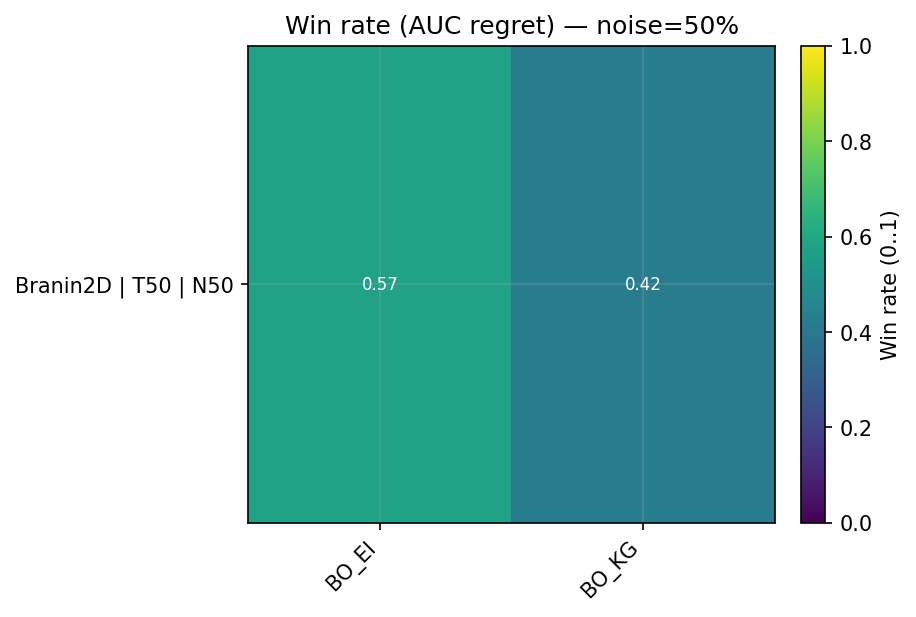

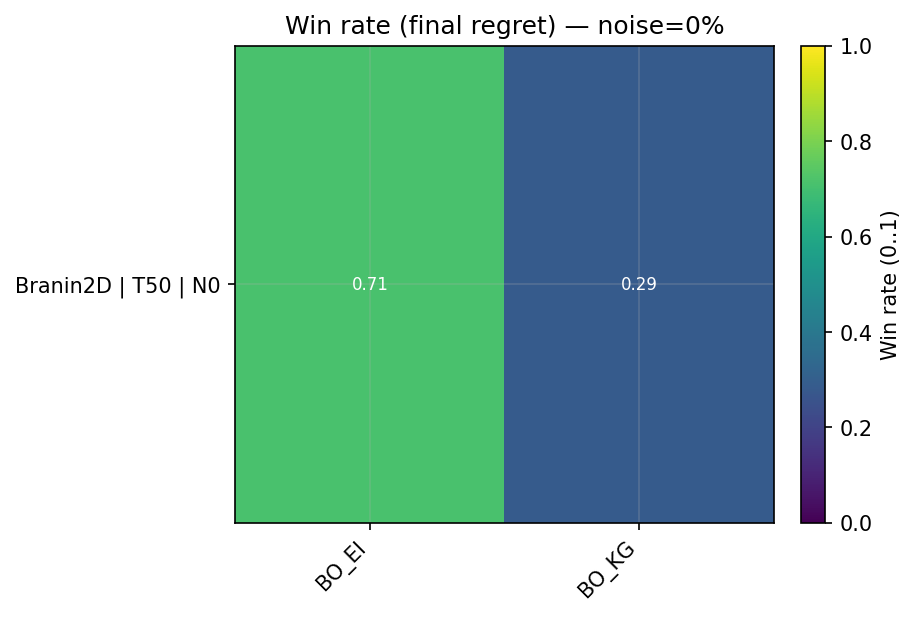

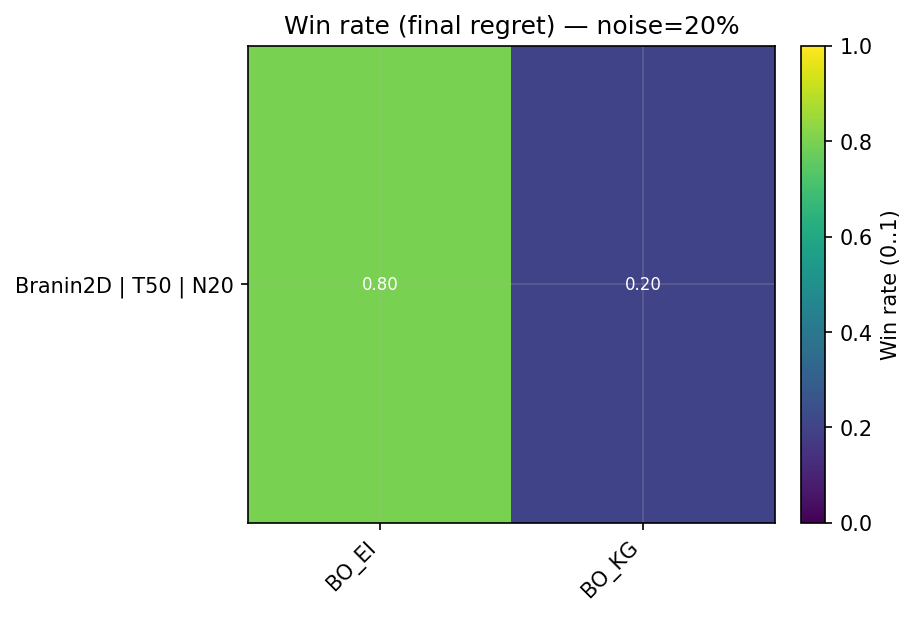

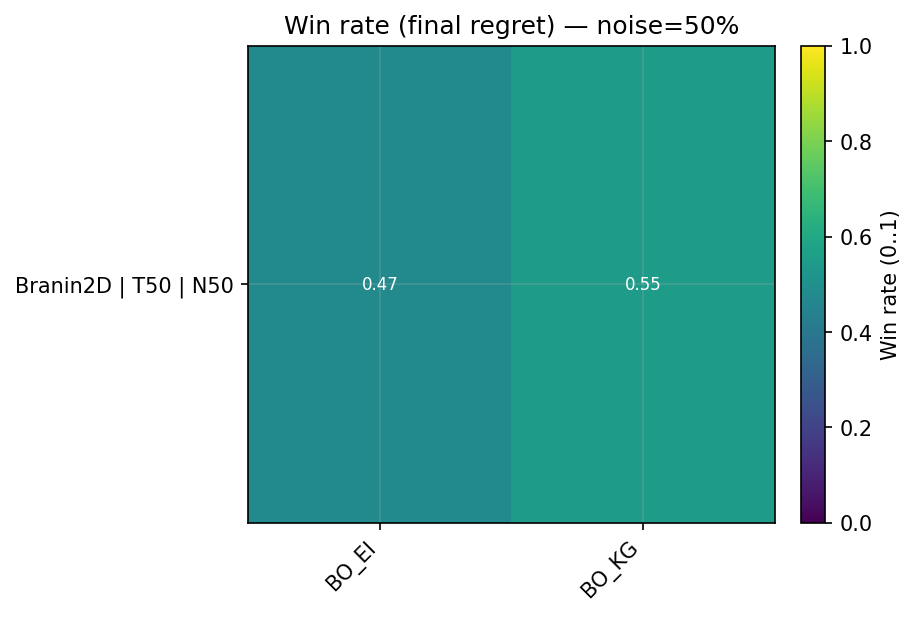

Global Best@T tables:


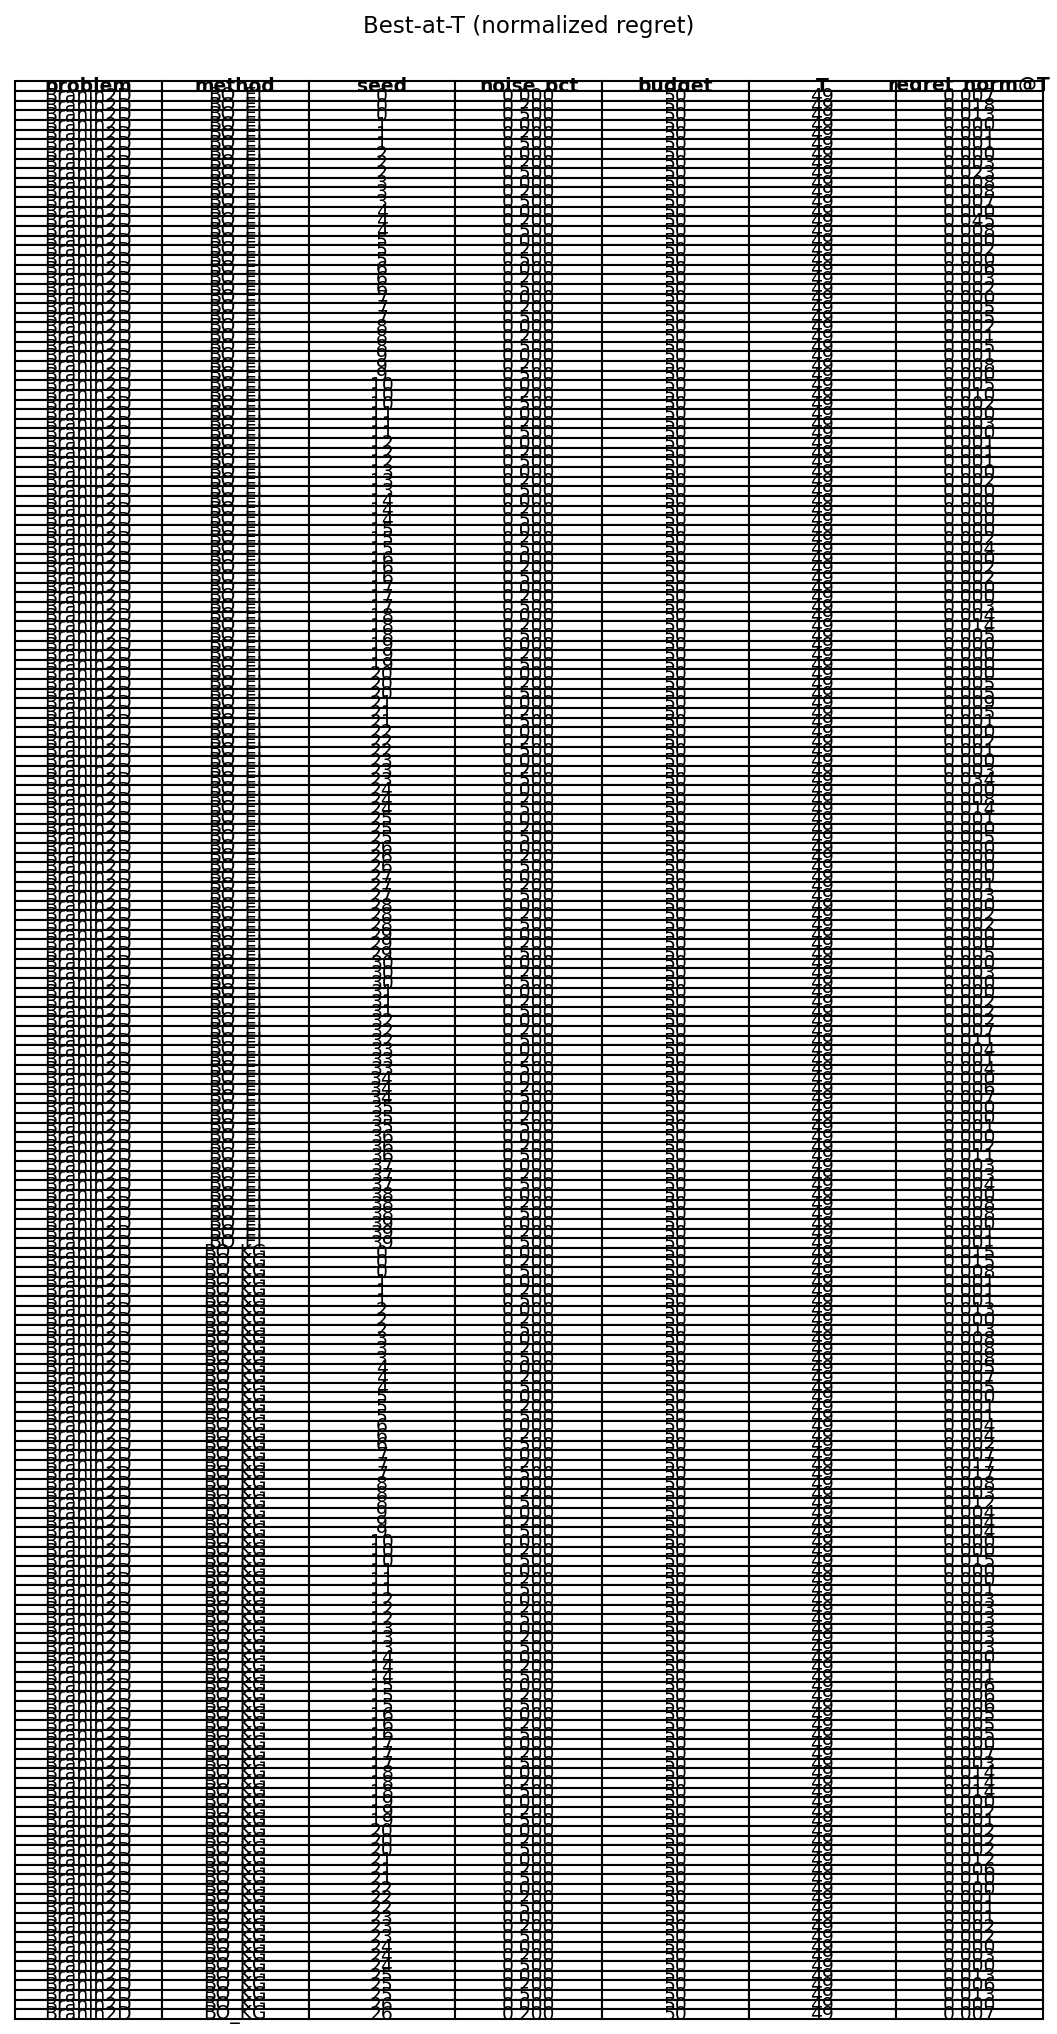

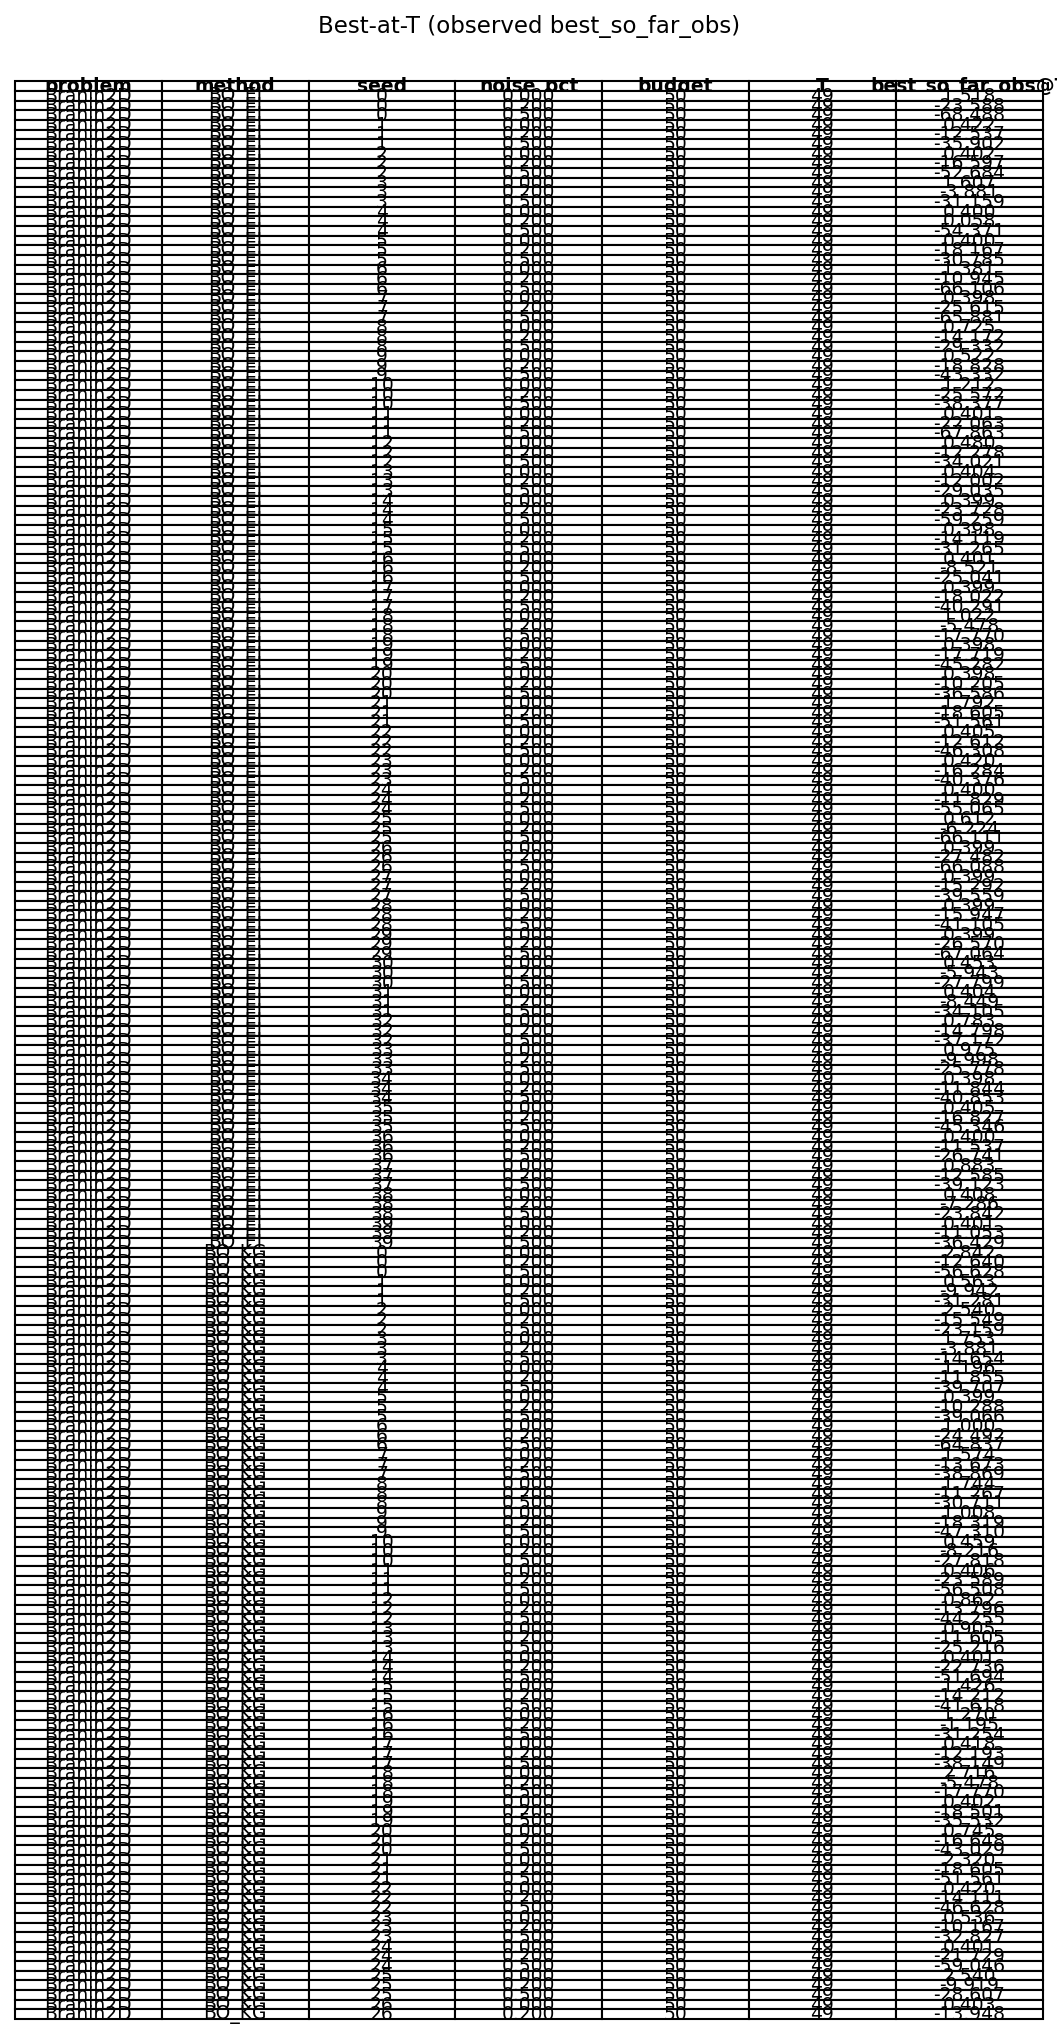

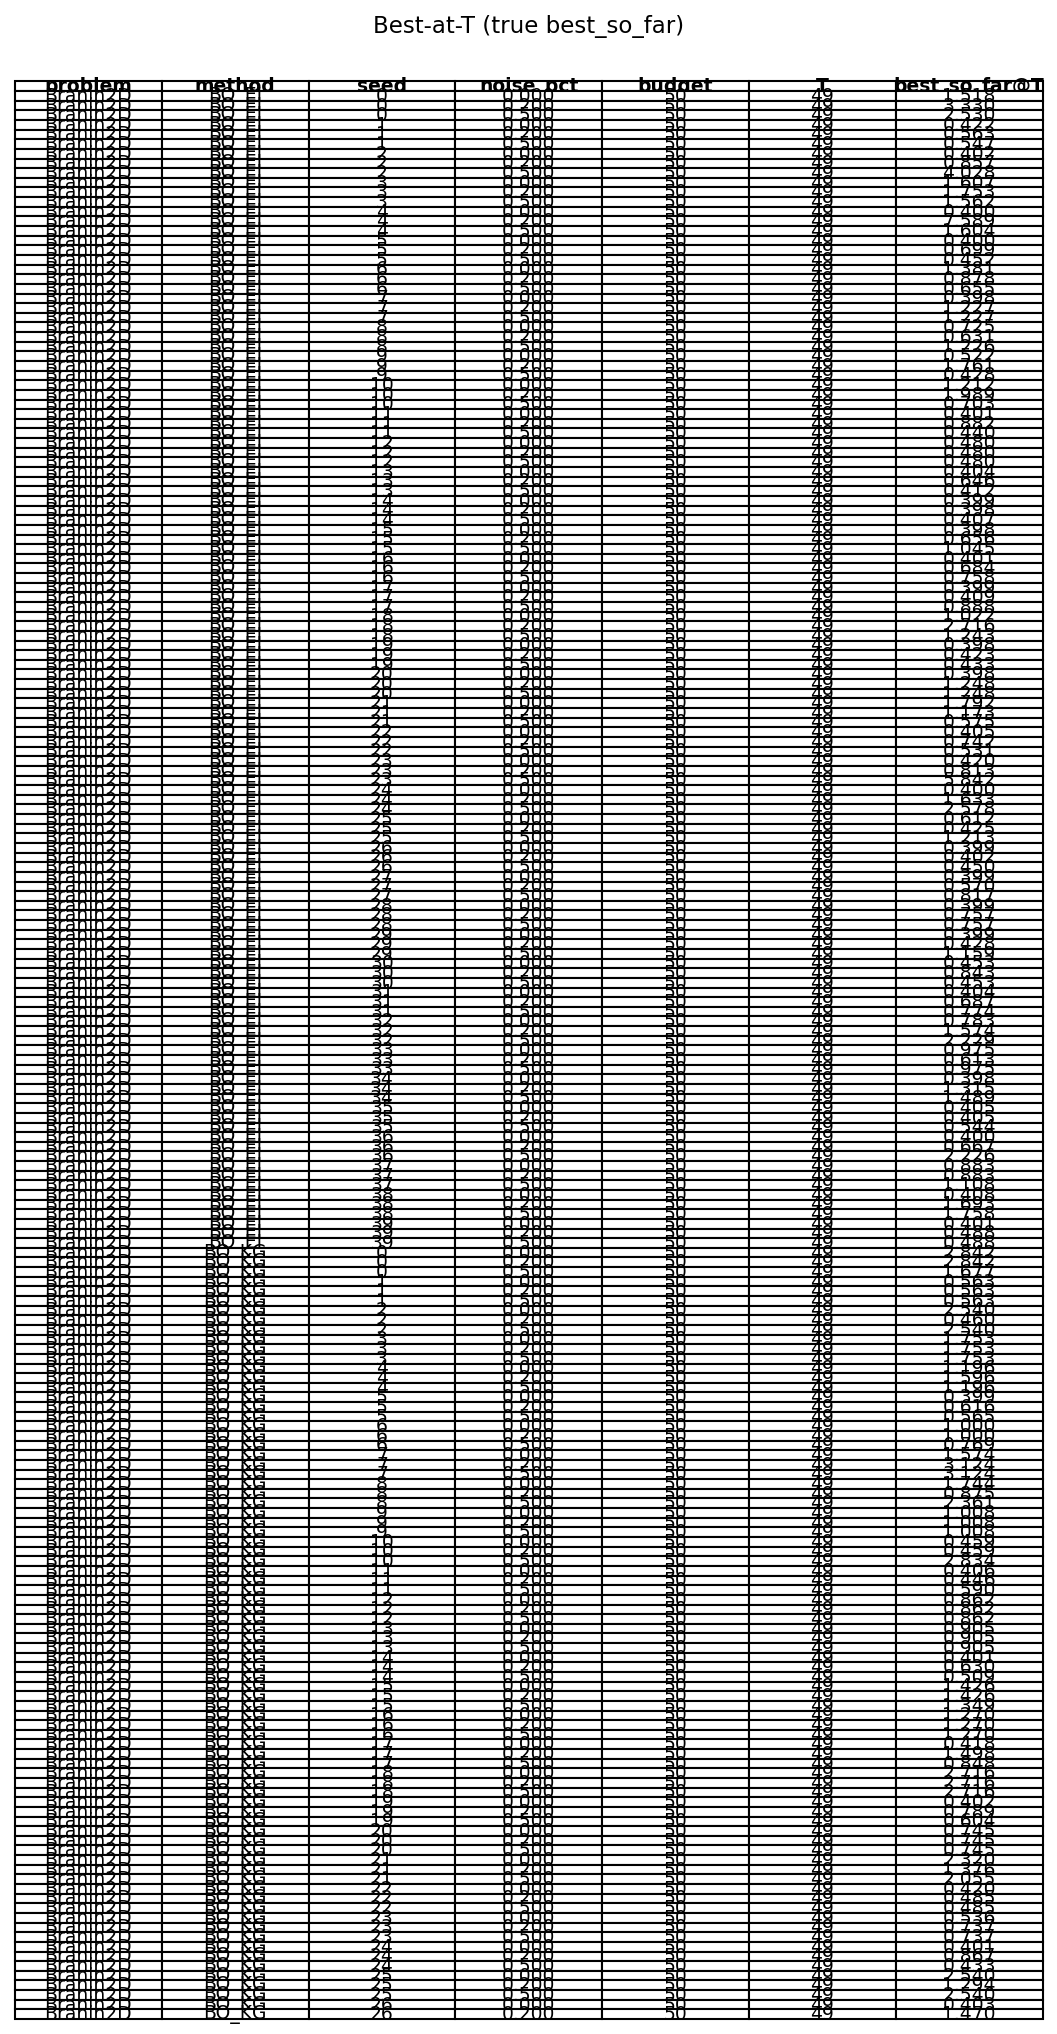

all_runs.csv shape: (12000, 21)


**Final rows per run (for boxplots):**

exp_name   problem method  dim  seed  noise_seed  \
49     SB4_BO_EI_vs_KG_noise  Branin2D  BO_EI    2     0      777000   
99     SB4_BO_EI_vs_KG_noise  Branin2D  BO_EI    2     0      777000   
149    SB4_BO_EI_vs_KG_noise  Branin2D  BO_EI    2     0      777000   
199    SB4_BO_EI_vs_KG_noise  Branin2D  BO_EI    2    10      777010   
249    SB4_BO_EI_vs_KG_noise  Branin2D  BO_EI    2    10      777010   
299    SB4_BO_EI_vs_KG_noise  Branin2D  BO_EI    2    10      777010   
349    SB4_BO_EI_vs_KG_noise  Branin2D  BO_EI    2    11      777011   
399    SB4_BO_EI_vs_KG_noise  Branin2D  BO_EI    2    11      777011   
11199  SB4_BO_EI_vs_KG_noise  Branin2D  BO_KG    2     4      777004   
11249  SB4_BO_EI_vs_KG_noise  Branin2D  BO_KG    2     4      777004   
11299  SB4_BO_EI_vs_KG_noise  Branin2D  BO_KG    2     5      777005   
11349  SB4_BO_EI_vs_KG_noise  Branin2D  BO_KG    2     5      777005   
11399  SB4_BO_EI_vs_KG_noise  Branin2D  BO_KG    2     5      777005   
11449  SB4_BO_EI_vs_KG_noise  Branin2D  BO_KG    2     6      777006   
11499  SB4_BO_EI_vs_KG_noise  Branin2D  BO_KG    2     6      777006   
11999  SB4_BO_EI_vs_KG_noise  Branin2D  BO_KG    2     9      777009   
5449   SB4_BO_EI_vs_KG_noise  Branin2D  BO_EI    2     6      777006   
11749  SB4_BO_EI_vs_KG_noise  Branin2D  BO_KG    2     8      777008   
5499   SB4_BO_EI_vs_KG_noise  Branin2D  BO_EI    2     6      777006   
5549   SB4_BO_EI_vs_KG_noise  Branin2D  BO_EI    2     6      777006   

       noise_pct  sigma_noise  budget  iter  ...  \
49           0.0     0.000000      50    49  ...   
99           0.2    10.282938      50    49  ...   
149          0.5    25.707345      50    49  ...   
199          0.0     0.000000      50    49  ...   
249          0.2    10.172826      50    49  ...   
299          0.5    25.432064      50    49  ...   
349          0.0     0.000000      50    49  ...   
399          0.2    10.339949      50    49  ...   
11199        0.2    10.233049      50    49  ...   
11249        0.5    25.582624      50    49  ...   
11299        0.0     0.000000      50    49  ...   
11349        0.2    10.302893      50    49  ...   
11399        0.5    25.757231      50    49  ...   
11449        0.0     0.000000      50    49  ...   
11499        0.2    10.507823      50    49  ...   
11999        0.5    25.722948      50    49  ...   
5449         0.0     0.000000      50    49  ...   
11749        0.0     0.000000      50    49  ...   
5499         0.2    10.507823      50    49  ...   
5549         0.5    26.269556      50    49  ...   

                                              x_uv  \
49        [0.5434895043158879, 0.5541085206765396]   
99      [0.48240569423775526, 0.11980788040756996]   
149      [0.5145949397560776, 0.30135349788573806]   
199       [0.9997302314172366, 0.4320829463537972]   
249    [0.06234255507120012, 0.014771084945037649]   
299     [0.28587589710911454, 0.19060380606556315]   
349      [0.9585814107405994, 0.15968667056279406]   
399      [0.9999144734531826, 0.36896607794890046]   
11199     [0.9052391066578886, 0.5451756561920531]   
11249     [0.9793059217908514, 0.5076795638389161]   
11299    [0.11982790122467324, 0.8103219094394395]   
11349    [0.9162921498603657, 0.10544233829682303]   
11399    [0.7312049180543336, 0.17386474599273793]   
11449    [0.25897982405531816, 0.5769300878052863]   
11499     [0.146167530572077, 0.48771068129006856]   
11999     [0.7657466907894787, 0.5621809896806946]   
5449      [0.2845440581255031, 0.6646793024245371]   
11749   [0.17812332474394288, 0.11898555729235105]   
5499      [0.2845440581255031, 0.6646793024245371]   
5549    [0.9460090776164051, 0.040422973693206354]   

                                            x_xy  \
49        [3.152342564738319, 8.311627810148094]   
99       [2.236085413566329, 1.7971182061135493]   
149       [2.718924096341164, 4.520302468286071]   
199      [9.995953471258549, 6.4812441953069575]   
249    [-4.06486167

**Aggregate (true regret) for curves:**

problem method  budget  noise_pct  iter     median        q25        q75  \
0   Branin2D  BO_EI      50        0.0     0  27.192097  13.890921  70.506640   
1   Branin2D  BO_EI      50        0.0     1  19.269922   8.738699  33.806408   
2   Branin2D  BO_EI      50        0.0     2  15.160100   5.298059  25.242206   
3   Branin2D  BO_EI      50        0.0     3   9.323280   2.834947  18.232169   
4   Branin2D  BO_EI      50        0.0     4   8.039648   2.298759  14.427364   
5   Branin2D  BO_EI      50        0.0     5   6.462237   1.319206  13.167625   
6   Branin2D  BO_EI      50        0.0     6   5.741040   1.274223   9.515726   
7   Branin2D  BO_EI      50        0.0     7   3.296446   1.191522   8.953586   
8   Branin2D  BO_EI      50        0.0     8   2.723142   0.929165   7.661794   
9   Branin2D  BO_EI      50        0.0     9   2.467451   0.875860   4.115428   
10  Branin2D  BO_EI      50        0.0    10   2.279119   0.850621   3.520558   
11  Branin2D  BO_EI      50        0.0    11   2.082010   0.850621   3.303248   
12  Branin2D  BO_EI      50        0.0    12   1.943059   0.850621   3.023749   
13  Branin2D  BO_EI      50        0.0    13   1.460639   0.574417   2.976220   
14  Branin2D  BO_EI      50        0.0    14   1.185247   0.549543   2.750810   
15  Branin2D  BO_EI      50        0.0    15   1.185247   0.468491   2.750810   
16  Branin2D  BO_EI      50        0.0    16   1.185247   0.381464   2.643498   
17  Branin2D  BO_EI      50        0.0    17   1.068226   0.381464   2.392925   
18  Branin2D  BO_EI      50        0.0    18   1.058220   0.381464   2.392925   
19  Branin2D  BO_EI      50        0.0    19   0.847360   0.120439   2.148435   

       n  
0   40.0  
1   40.0  
2   40.0  
3   40.0  
4   40.0  
5   40.0  
6   40.0  
7   40.0  
8   40.0  
9   40.0  
10  40.0  
11  40.0  
12  40.0  
13  40.0  
14  40.0  
15  40.0  
16  40.0  
17  40.0  
18  40.0  
19  40.0

**Aggregate (normalized regret) for curves:**

problem method  iter    median       q25       q75  noise_pct
0   Branin2D  BO_EI     0  0.169589  0.086634  0.439730        0.0
1   Branin2D  BO_EI     1  0.120181  0.054501  0.210841        0.0
2   Branin2D  BO_EI     2  0.094549  0.033043  0.157429        0.0
3   Branin2D  BO_EI     3  0.058147  0.017681  0.113709        0.0
4   Branin2D  BO_EI     4  0.050141  0.014337  0.089979        0.0
5   Branin2D  BO_EI     5  0.040303  0.008228  0.082123        0.0
6   Branin2D  BO_EI     6  0.035805  0.007947  0.059347        0.0
7   Branin2D  BO_EI     7  0.020559  0.007431  0.055841        0.0
8   Branin2D  BO_EI     8  0.016983  0.005795  0.047784        0.0
9   Branin2D  BO_EI     9  0.015389  0.005462  0.025667        0.0
10  Branin2D  BO_EI    10  0.014214  0.005305  0.021957        0.0
11  Branin2D  BO_EI    11  0.012985  0.005305  0.020601        0.0
12  Branin2D  BO_EI    12  0.012118  0.005305  0.018858        0.0
13  Branin2D  BO_EI    13  0.009110  0.003582  0.018562        0.0
14  Branin2D  BO_EI    14  0.007392  0.003427  0.017156        0.0
15  Branin2D  BO_EI    15  0.007392  0.002922  0.017156        0.0
16  Branin2D  BO_EI    16  0.007392  0.002379  0.016487        0.0
17  Branin2D  BO_EI    17  0.006662  0.002379  0.014924        0.0
18  Branin2D  BO_EI    18  0.006600  0.002379  0.014924        0.0
19  Branin2D  BO_EI    19  0.005285  0.000751  0.013399        0.0

In [3]:
outdir = run_and_collect(main.EXP_NAME)
show_all_core_plots(outdir)
show_core_dataframes(outdir)


### Trajectory Plots

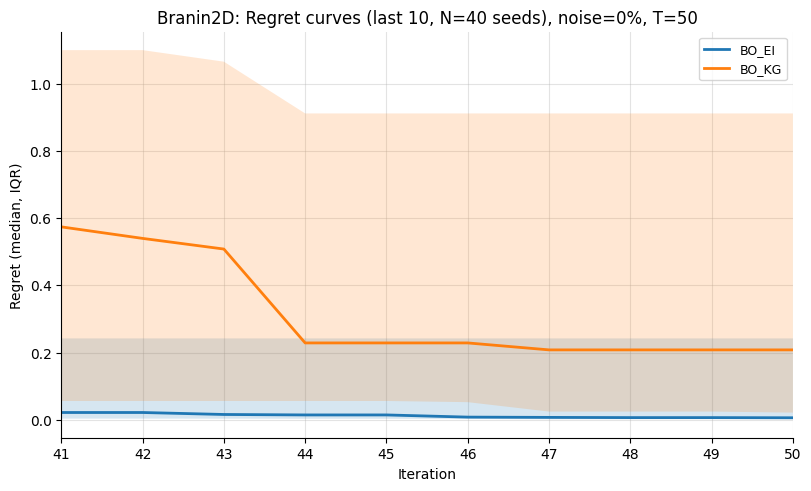

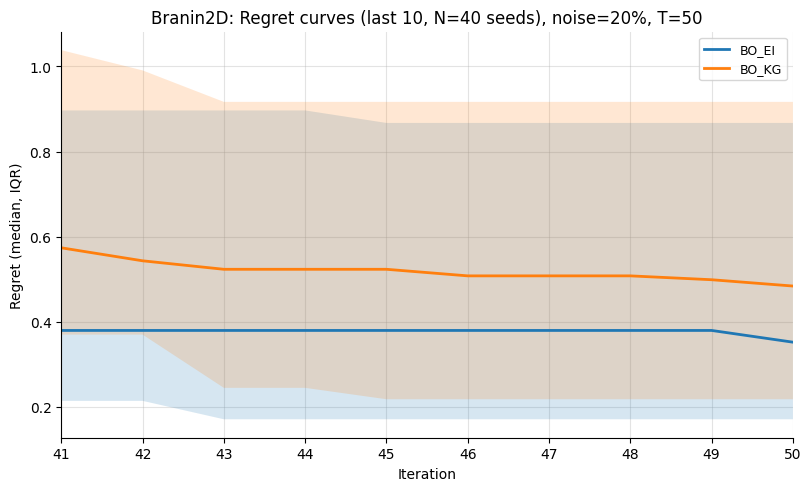

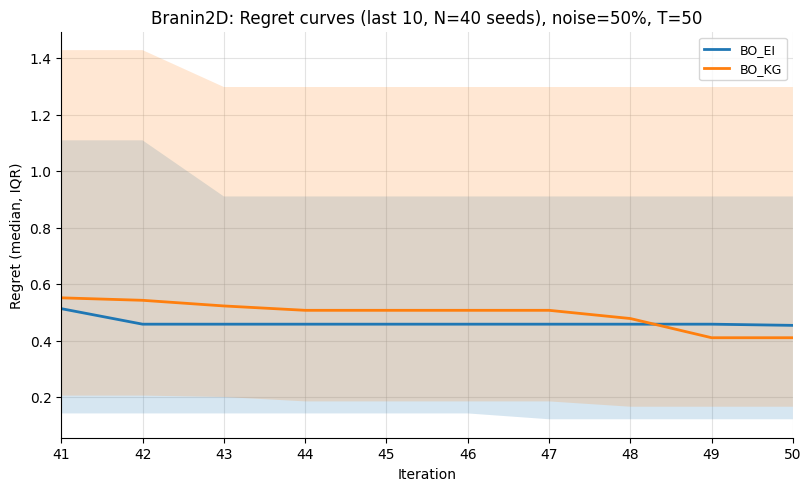

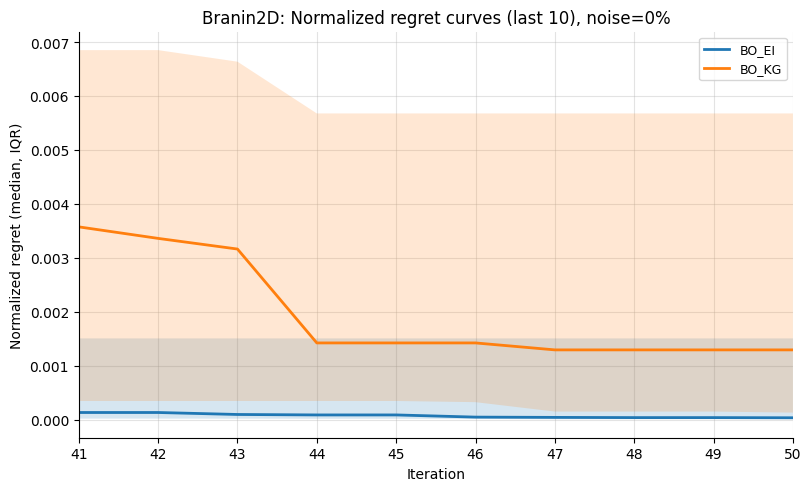

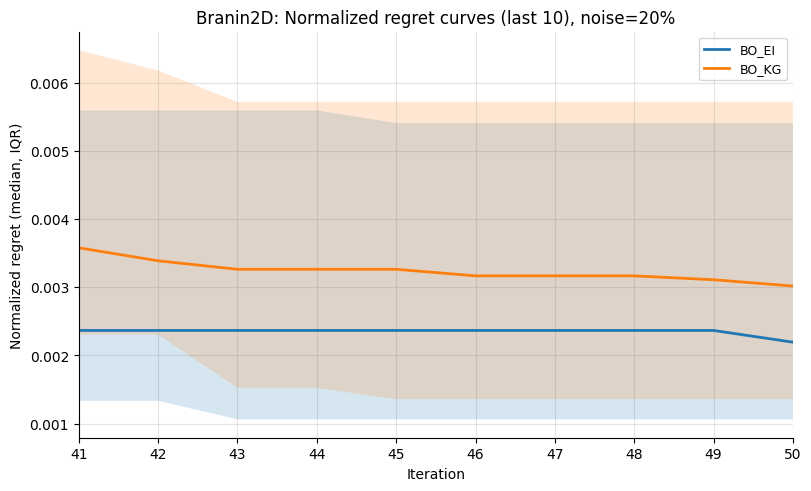

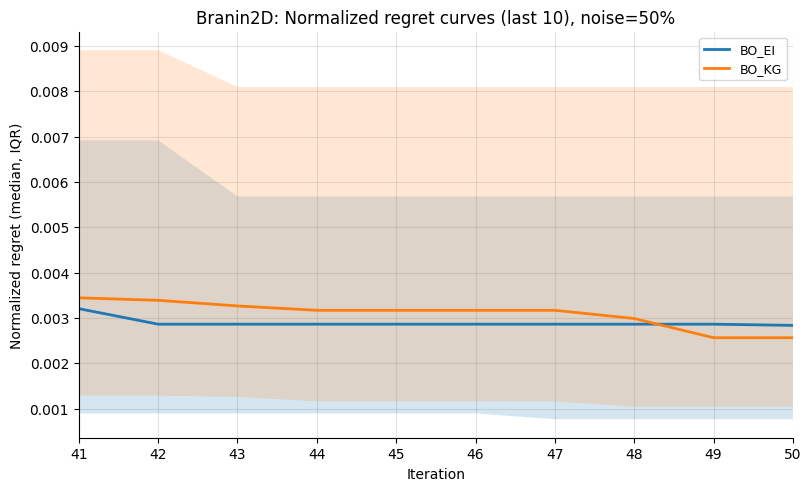

In [4]:
# === Last-10 Regret Curves (SB4: BO_EI vs BO_KG), x bis T=max, display-only ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Daten laden
df_all = load_logs(outdir)
dfn    = add_normalized_regret(df_all.copy())

# volle Aggregate (für T-Bestimmung)
agg_true_full = aggregate_regret(df_all, use_observed=False)   # cols: problem, method, [budget], noise_pct, iter, median, q25, q75, n
aggn_full     = aggregate_regret_norm(dfn)                     # cols: problem, method, [budget], noise_pct, iter, median, q25, q75, n

# gewünschte Reihenfolge für alle Plots (SB4)
methods = ["BO_EI", "BO_KG"]

# last-10 pro Methode (zum Plotten)
def _last_k_by_method(agg: pd.DataFrame, k: int) -> pd.DataFrame:
    cols = agg.columns.tolist()
    has_budget = "budget" in agg.columns
    pieces = []
    for p in sorted(agg["problem"].unique()):
        ap = agg[agg["problem"] == p]
        budgets = sorted(ap["budget"].unique()) if has_budget else [None]
        for b in budgets:
            ab = ap if b is None else ap[ap["budget"] == b]
            for n in sorted(ab["noise_pct"].unique()):
                sub = ab[ab["noise_pct"] == n]
                if sub.empty:
                    continue
                present = [m for m in methods if m in set(sub["method"])]
                for m in present:
                    sm = sub[sub["method"] == m].sort_values("iter")
                    iters = sorted(sm["iter"].unique())
                    take = iters[-min(k, len(iters)):]
                    pieces.append(sm[sm["iter"].isin(take)])
    return pd.concat(pieces, ignore_index=True)[cols]

agg_true_l10 = _last_k_by_method(agg_true_full, k=10)
aggn_l10     = _last_k_by_method(aggn_full,     k=10)

# T=max je (problem, noise[, budget]) aus den vollen Aggregaten bestimmen
def _Tinfo_from_full(agg_full: pd.DataFrame):
    info = {}
    has_budget = "budget" in agg_full.columns
    for p in agg_full["problem"].unique():
        ap = agg_full[agg_full["problem"] == p]
        budgets = sorted(ap["budget"].unique()) if has_budget else [None]
        for b in budgets:
            ab = ap if b is None else ap[ap["budget"] == b]
            for n in sorted(ab["noise_pct"].unique()):
                sub = ab[ab["noise_pct"] == n]
                if sub.empty:
                    continue
                it_min = int(sub["iter"].min())
                it_max = int(sub["iter"].max())
                x_off  = 1 if it_min == 0 else 0     # 0-based → +1
                T_end  = it_max + x_off               # z.B. 49+1 = 50
                info[(p, n, b)] = (T_end, x_off)
    return info

Tinfo_true = _Tinfo_from_full(agg_true_full)
Tinfo_norm = _Tinfo_from_full(aggn_full)

def _plot_windowed_curves(slice_lastk: pd.DataFrame, Tinfo_full: dict,
                          title_prefix: str, ylabel: str, k:int=10):
    has_budget = "budget" in slice_lastk.columns
    for p in sorted(slice_lastk["problem"].unique()):
        ap = slice_lastk[slice_lastk["problem"] == p]
        budgets = sorted(ap["budget"].unique()) if has_budget else [None]
        for b in budgets:
            ab = ap if b is None else ap[ap["budget"] == b]
            for n in sorted(ab["noise_pct"].unique()):
                key = (p, n, b)
                if key not in Tinfo_full:
                    continue
                T_end, x_off = Tinfo_full[key]
                xmin, xmax = max(1, T_end - (k - 1)), T_end
                sub = ab[ab["noise_pct"] == n]
                if sub.empty:
                    continue
                present = [m for m in methods if m in set(sub["method"])]

                fig, ax = plt.subplots(figsize=(8, 4.8))
                for m in present:
                    sm = sub[sub["method"] == m].sort_values("iter")
                    x  = sm["iter"].to_numpy(dtype=float) + x_off
                    y  = sm["median"].to_numpy(dtype=float)
                    q1 = sm["q25"].to_numpy(dtype=float)
                    q3 = sm["q75"].to_numpy(dtype=float)
                    ax.plot(x, y, label=m, linewidth=2.0)
                    ax.fill_between(x, q1, q3, alpha=0.18)

                seeds_txt = ""
                if "n" in sub.columns and sub["n"].notna().any():
                    try: seeds_txt = f", N={int(sub['n'].max())} seeds"
                    except: pass

                title = f"{p}: {title_prefix} (last {k}{seeds_txt}), noise={int(round(100*float(n)))}%"
                if b is not None:
                    title += f", T={int(b)}"

                ax.set_title(title)
                ax.set_xlabel("Iteration")
                ax.set_ylabel(ylabel)
                ax.set_xlim(xmin, xmax)                # endet garantiert bei T=max
                xt = list(range(xmin, xmax+1))
                if len(xt) > 10:
                    step = int(np.ceil(len(xt)/10))
                    xt = list(range(xmin, xmax+1, step))
                    if xt[-1] != xmax: xt.append(xmax)
                ax.set_xticks(xt)
                ax.grid(True, alpha=0.35); ax.set_axisbelow(True)
                for s in ("top","right"): ax.spines[s].set_visible(False)
                ax.legend(loc="upper right")
                plt.show()

# Anzeigen: true & normalized – je Plot läuft die x-Achse bis T=max (z.B. 50)
_plot_windowed_curves(agg_true_l10, Tinfo_true, title_prefix="Regret curves",            ylabel="Regret (median, IQR)", k=10)
_plot_windowed_curves(aggn_l10,     Tinfo_norm, title_prefix="Normalized regret curves", ylabel="Normalized regret (median, IQR)", k=10)


### Inline - Boxplots

In [13]:
# === INLINE BOXPLOT: zwei Methoden je Noise-Level (Final regret @T)
# Beide Beschriftungen UNTERHALB: 1) Methode (näher an Achse), 2) Noise level darunter
from pathlib import Path
from typing import Optional, Sequence
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from matplotlib import transforms as mtransforms
from IPython.display import Markdown, display
import evaluator as ev

try:
    import tb_style
    tb_style.apply()
except Exception:
    pass

def _value_col_from_metric(metric: str) -> str:
    m = metric.lower()
    if m in ("regret","true"): return "regret"
    if m in ("regret_obs","obs"): return "regret_obs"
    if m in ("regret_norm","norm"): return "regret_norm"
    if m in ("best_so_far","best"): return "best_so_far"
    if m in ("best_so_far_obs","best_obs"): return "best_so_far_obs"
    raise ValueError

def _ylabel_from_metric(metric: str) -> str:
    m = metric.lower()
    if m == "regret": return "Final regret @ T"
    if m == "regret_obs": return "Final observed regret @ T"
    if m == "regret_norm": return "Final normalized regret @ T"
    if m == "best_so_far": return "Final best value @ T"
    if m == "best_so_far_obs": return "Final observed best value @ T"
    return metric

def plot_box_two_methods_by_noise_inline(
    outdir: Path,
    problem: str = "Branin2D",
    methods: Sequence[str] = ("BO_EI","BO_KG"),
    metric: str = "regret",
    budget: Optional[int] = None,
    show_all_seeds: bool = True,
    highlight_seed: Optional[int] = None,
    jitter: float = 0.12,
    pair_gap: float = 0.18,
    box_width: float = 0.28,
    ypad: float = 0.05,
    decimals: int = 3,
    median_display: str = "table",     # 'table' | 'hover' | 'none'
    method_y: float = -0.14,           # y-Position (relativ zur Achse) für Methodenlabels
    noise_y: float = -0.22,            # y-Position (relativ zur Achse) für Noise-Labels
):
    col = _value_col_from_metric(metric)
    ylabel = _ylabel_from_metric(metric)

    df = ev.load_logs(outdir)
    try:
        base = ev._final_rows_per_run(df)
    except Exception:
        keys = ["problem","method","seed","budget"]
        if "noise_pct" in df.columns: keys.append("noise_pct")
        base = df.sort_values("iter").groupby(keys, as_index=False).tail(1)
    if base.empty: raise ValueError("No data after final-row filtering.")
    if "noise_pct" not in base.columns:
        base = base.copy(); base["noise_pct"] = 0.0

    sub = base[(base["problem"] == problem) & (base["method"].isin(methods))].copy()
    if sub.empty: raise ValueError(f"No rows for problem={problem} with methods={list(methods)}")

    if "budget" in sub.columns and sub["budget"].notna().any():
        if budget is None: budget = int(sub["budget"].max())
        sub = sub[sub["budget"] == budget]
    else:
        budget = int(sub["iter"].max()) + 1
    if sub.empty: raise ValueError("No rows at the requested T (budget).")

    # gemeinsame Noise-Levels (beide Methoden vorhanden)
    noise_a = set(sub[sub["method"] == methods[0]]["noise_pct"].unique())
    noise_b = set(sub[sub["method"] == methods[1]]["noise_pct"].unique())
    noise_levels = sorted(noise_a.intersection(noise_b)) or sorted(sub["noise_pct"].unique())

    # Daten
    data_a = [sub[(sub["method"] == methods[0]) & (sub["noise_pct"] == n)][col].to_numpy() for n in noise_levels]
    data_b = [sub[(sub["method"] == methods[1]) & (sub["noise_pct"] == n)][col].to_numpy() for n in noise_levels]

    n_seeds = int(sub["seed"].nunique()) if "seed" in sub.columns else int(max(len(d) for d in data_a + data_b))
    y_min = 0.0 if col in ("regret","regret_obs","regret_norm") else float(np.nanmin([np.nanmin(d) for d in data_a + data_b if d.size]))
    ymax = np.nanmax([np.nanmax(d) for d in data_a + data_b if d.size])
    y_max = (1.0 if not np.isfinite(ymax) else ymax) * (1.0 + ypad)

    # Positionierung: pro Noise-Level ein Paar
    centers = np.arange(1, len(noise_levels) + 1, dtype=float)
    pos_a = centers - pair_gap
    pos_b = centers + pair_gap
    labels_noise = [f"{int(round(100*n))}%" for n in noise_levels]

    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    bp_a = ax.boxplot(data_a, positions=pos_a, widths=box_width, showfliers=False)
    bp_b = ax.boxplot(data_b, positions=pos_b, widths=box_width, showfliers=False)

    # Seeds (grau)
    if show_all_seeds:
        for i in range(len(noise_levels)):
            va, vb = data_a[i], data_b[i]
            if va.size:
                xs = pos_a[i] + (np.linspace(-jitter, jitter, va.size) if va.size > 1 else np.array([0.0]))
                ax.scatter(xs, va, s=20, c="0.6", zorder=3)
            if vb.size:
                xs = pos_b[i] + (np.linspace(-jitter, jitter, vb.size) if vb.size > 1 else np.array([0.0]))
                ax.scatter(xs, vb, s=20, c="0.6", zorder=3)

    # Highlight-Seed
    if highlight_seed is not None and "seed" in sub.columns:
        hs = sub[sub["seed"] == int(highlight_seed)]
        for i, n in enumerate(noise_levels):
            va = hs[(hs["method"] == methods[0]) & (hs["noise_pct"] == n)][col].to_numpy()
            vb = hs[(hs["method"] == methods[1]) & (hs["noise_pct"] == n)][col].to_numpy()
            if va.size: ax.scatter(np.repeat(pos_a[i], va.size), va, s=36, c="black", zorder=4)
            if vb.size: ax.scatter(np.repeat(pos_b[i], vb.size), vb, s=36, c="black", zorder=4)

    # Medians NICHT im Plot (oder optional 'hover')
    if median_display == "hover":
        med_a = [np.nanmedian(d) if d.size else np.nan for d in data_a]
        med_b = [np.nanmedian(d) if d.size else np.nan for d in data_b]
        voff = 0.02 * (y_max - y_min)
        for i in range(len(noise_levels)):
            if np.isfinite(med_a[i]): ax.text(pos_a[i], med_a[i]+voff, f"{med_a[i]:.{decimals}f}", ha="center", va="bottom", fontsize=9)
            if np.isfinite(med_b[i]): ax.text(pos_b[i], med_b[i]+voff, f"{med_b[i]:.{decimals}f}", ha="center", va="bottom", fontsize=9)

    # Achsen & Grid
    ax.set_ylim(y_min, y_max)
    ax.set_ylabel(ylabel)
    ax.grid(True, alpha=0.35); ax.set_axisbelow(True)
    for s in ("top","right"): ax.spines[s].set_visible(False)

    # Standard-x-Ticks ausblenden, wir setzen zwei Textzeilen unten
    ax.set_xticks([])
    ax.set_xlabel("")  # keine Standardbeschriftung

    # Platz nach unten erhöhen für zwei Zeilen Labels
    fig.subplots_adjust(bottom=max(0.28, fig.subplotpars.bottom))

    # Beide Beschriftungen UNTERHALB
    trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)

    # 1) Methodenlabels an JEDEM Box-Spot (näher an Achse)
    for p in pos_a:
        ax.text(p, method_y, methods[0], transform=trans, ha="center", va="top", fontsize=9, clip_on=False)
    for p in pos_b:
        ax.text(p, method_y, methods[1], transform=trans, ha="center", va="top", fontsize=9, clip_on=False)

    # 2) Noise-Labels je PAAR (zentriert darunter)
    for c, lab in zip(centers, labels_noise):
        ax.text(c, noise_y, lab, transform=trans, ha="center", va="top", fontsize=9, clip_on=False)

    # Titel
    title = f"{problem} — {methods[0]} vs {methods[1]} — {ylabel.replace('Final ','').replace(' @ T',' at T')} (N={n_seeds}), T={budget}"
    ax.set_title(title)
    plt.show()

    # Tabelle (inkl. Median)
    summary = (
        sub[sub["noise_pct"].isin(noise_levels)]
        .groupby(["noise_pct","method"])[col]
        .agg(n="count", median="median",
             q25=lambda s: s.quantile(0.25), q75=lambda s: s.quantile(0.75),
             mean="mean", std="std", min="min", max="max")
        .reset_index()
    )
    summary["alpha"] = summary["noise_pct"].map(lambda n: f"{int(round(100*n))}%")
    summary = summary[["alpha","method","n","median","q25","q75","mean","std","min","max"]].round(decimals)
    if median_display == "table":
        display(Markdown("**Per-noise × method summary (final @ T):**"))
        display(summary)
    return summary


C:\Users\marti\AppData\Local\Temp\ipykernel_37480\998087438.py:141: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(bottom=max(0.28, fig.subplotpars.bottom))


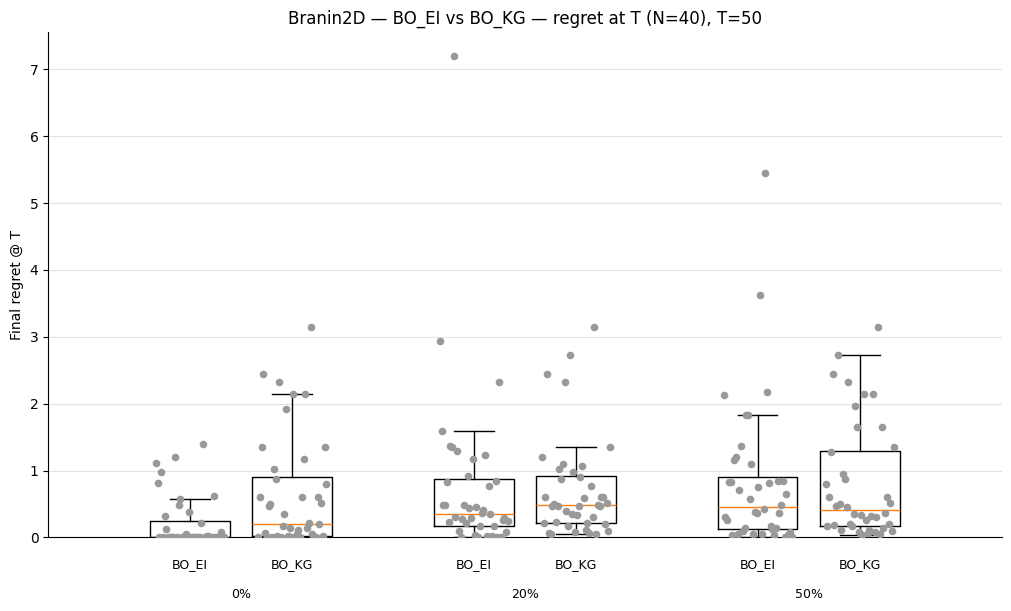

**Per-noise × method summary (final @ T):**

alpha method   n  median    q25    q75   mean    std    min    max
0    0%  BO_EI  40   0.006  0.002  0.242  0.213  0.385  0.000  1.394
1    0%  BO_KG  40   0.208  0.021  0.911  0.640  0.838  0.000  3.151
2   20%  BO_EI  40   0.352  0.171  0.867  0.750  1.230  0.000  7.191
3   20%  BO_KG  40   0.484  0.218  0.917  0.717  0.748  0.048  3.151
4   50%  BO_EI  40   0.454  0.122  0.911  0.809  1.073  0.009  5.444
5   50%  BO_KG  40   0.411  0.167  1.298  0.806  0.870  0.035  3.151

In [17]:
outdir = find_latest_results(main.EXP_NAME)

_ = plot_box_two_methods_by_noise_inline(
    outdir,
    problem="Branin2D",
    methods=("BO_EI","BO_KG"),
    metric="regret",
    budget=50,
    median_display="table",
    method_y=-0.04,  # Methode (näher an Achse)
    noise_y=-0.1    # Noise darunter
)


### 2D/ 3D samples

In [2]:
from pathlib import Path
from evaluator import load_logs

# >>> Deinen absoluten Run-Ordner hier einsetzen (raw-string r"...")
outdir = Path(r"C:\Users\marti\OneDrive\Documents\Bildung\Studium\Data_Science\IU-Data_Science\Abschlussarbeit\Code_Pipeline\Final-Sub-Benchmarks\results\20251027_224019_SB4_BO_EI_vs_KG_noise")
assert outdir.exists(), f"Pfad nicht gefunden: {outdir}"
assert (outdir / "all_runs.csv").exists(), f"all_runs.csv fehlt unter: {outdir}"

print("✓ Using results dir:", outdir)

# ab hier wie gehabt weiter
df_all = load_logs(outdir)
PROBLEM = str(df_all["problem"].iloc[0])


✓ Using results dir: C:\Users\marti\OneDrive\Documents\Bildung\Studium\Data_Science\IU-Data_Science\Abschlussarbeit\Code_Pipeline\Final-Sub-Benchmarks\results\20251027_224019_SB4_BO_EI_vs_KG_noise


Kept 2 pair(s): [('BO_EI', 0.2, 14, 50), ('BO_EI', 0.2, 4, 50)]
✓ Built 2 combined images in: C:\Users\marti\OneDrive\Documents\Bildung\Studium\Data_Science\IU-Data_Science\Abschlussarbeit\Code_Pipeline\Final-Sub-Benchmarks\results\20251027_224019_SB4_BO_EI_vs_KG_noise\samples_pairs


**Combined final sample pairs (2D|3D) shown:** 2


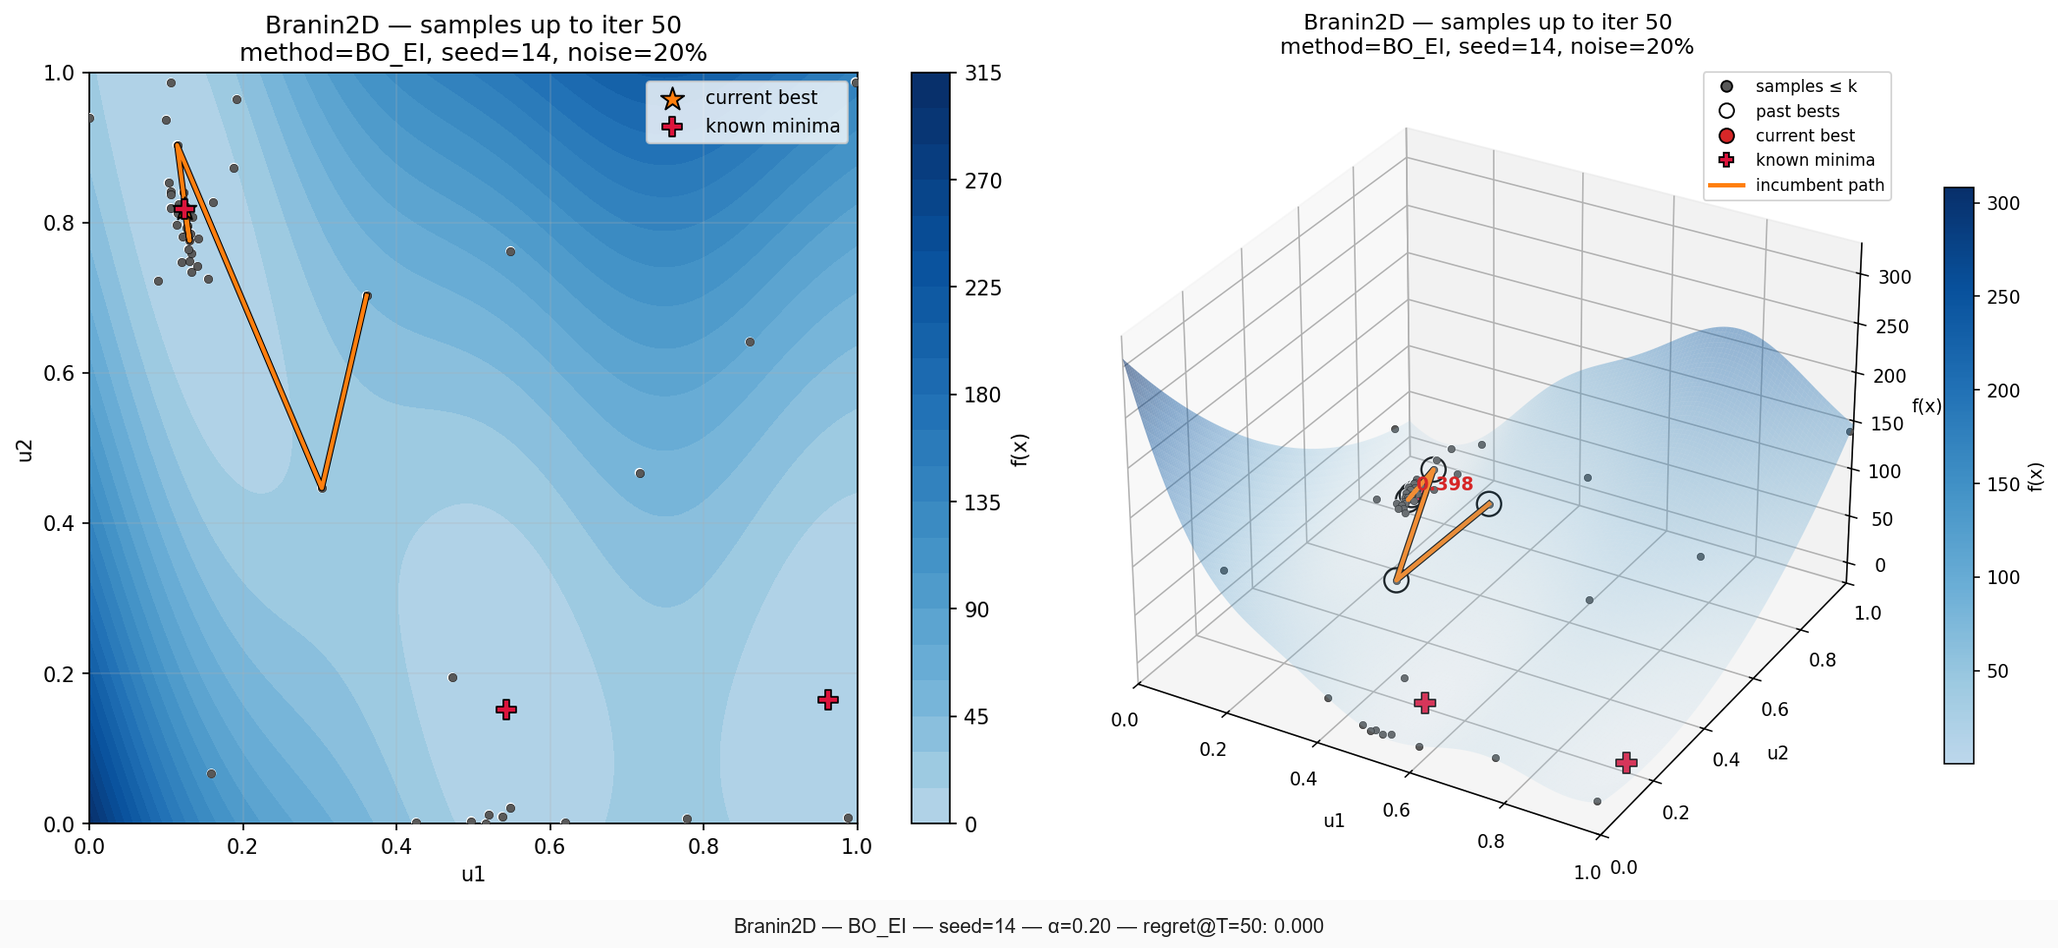
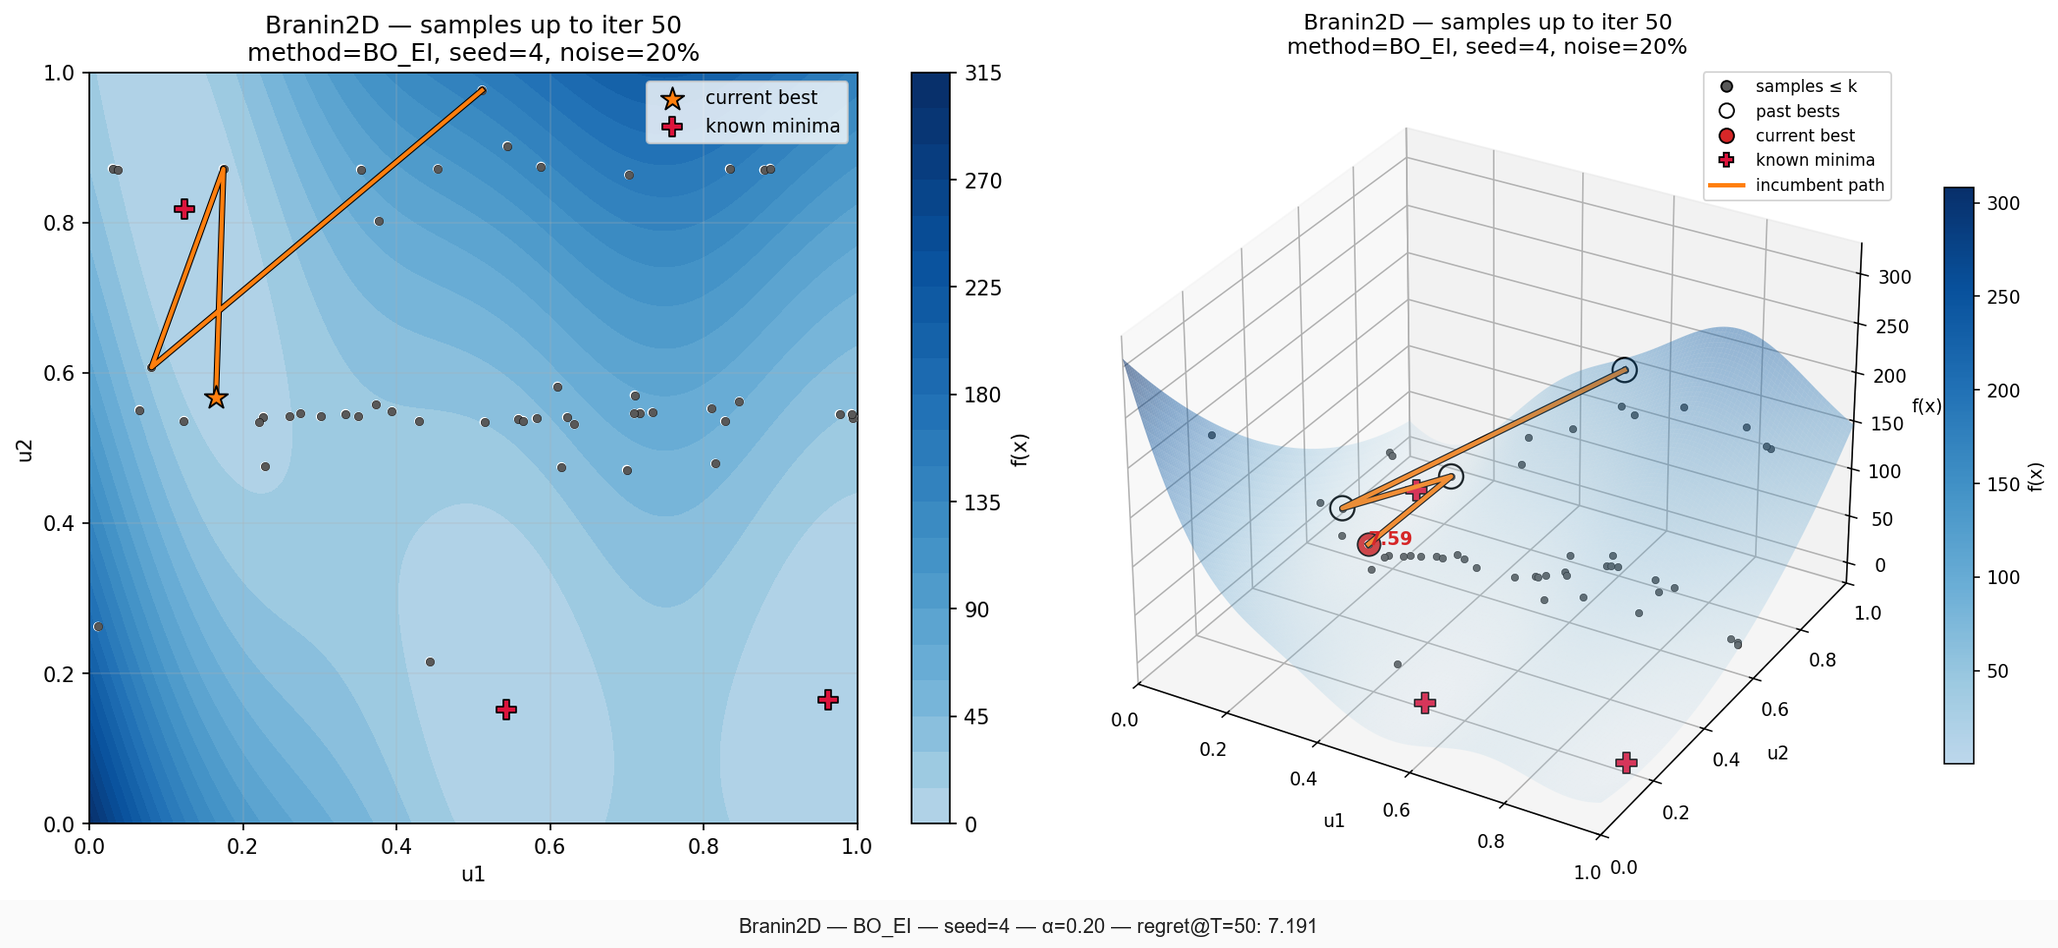

In [15]:
# === Build side-by-side COMBINED images (2D left, 3D right) with equal size + best@T footer ===
from pathlib import Path
from IPython.display import HTML, display, Markdown
import base64, re, mimetypes
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import pandas as pd

# Helper: Pillow-kompatible Textbreite/-höhe
def _text_wh(draw, text: str, font):
    if hasattr(draw, "textbbox"):
        l, t, r, b = draw.textbbox((0, 0), text, font=font)
        return (r - l, b - t)
    if hasattr(font, "getbbox"):
        l, t, r, b = font.getbbox(text)
        return (r - l, b - t)
    if hasattr(font, "getsize"):
        return font.getsize(text)
    return (len(text) * 8, 16)

# 0) Resolve run dir
def _resolve_outdir():
    if "OUTDIR" in globals(): return Path(OUTDIR)
    if "outdir" in globals(): return Path(outdir)
    return Path("results")
OUTDIR = _resolve_outdir()
SAMPLES_ROOT = OUTDIR / "samples"
assert SAMPLES_ROOT.exists(), f"No samples/ under {OUTDIR}"

# Logs laden (für best@T)
from evaluator import load_logs
df_all = load_logs(OUTDIR).sort_values("iter")

# best@T aus all_runs bestimmen (true)
def _best_at_T_for(df: pd.DataFrame, problem: str, method: str, seed: int, alpha: float):
    sub = df[
        (df["problem"] == problem) &
        (df["method"]  == method)  &
        (df["seed"]    == int(seed)) &
        (df["noise_pct"].round(5) == round(float(alpha), 5))
    ].sort_values("iter").copy()
    if sub.empty:
        return None, None  # best, T_end

    it_min = int(sub["iter"].min())
    it_max = int(sub["iter"].max())
    x_off  = 1 if it_min == 0 else 0
    T_end  = it_max + x_off

    best = None
    if "best_so_far" in sub.columns and sub["best_so_far"].notna().any():
        best = float(sub.tail(1)["best_so_far"].iloc[0])
    elif "y" in sub.columns and sub["y"].notna().any():
        best = float(np.minimum.accumulate(sub["y"].to_numpy(dtype=float))[-1])
    elif "y_noisy" in sub.columns and sub["y_noisy"].notna().any():
        best = float(np.minimum.accumulate(sub["y_noisy"].to_numpy(dtype=float))[-1])
    return best, T_end

# --- WELCHEN Wert willst du zeigen? ---
METRIC = "regret"          # Alternativen: "regret_obs" | "regret_norm"
LABEL  = {"regret":"regret", "regret_obs":"observed regret", "regret_norm":"normalized regret"}[METRIC]

def _value_at_T_for(df: pd.DataFrame, problem: str, method: str, seed: int, alpha: float, metric: str):
    """Hole den gewünschten Wert @ T (letzte Iteration) samt T (1-basiert)."""
    sub = df[
        (df["problem"] == problem) &
        (df["method"]  == method)  &
        (df["seed"]    == int(seed)) &
        (df["noise_pct"].round(5) == round(float(alpha), 5))
    ].sort_values("iter").copy()
    if sub.empty:
        return None, None
    it_min = int(sub["iter"].min())
    it_max = int(sub["iter"].max())
    x_off  = 1 if it_min == 0 else 0
    T_end  = it_max + x_off

    col = {"regret":"regret", "regret_obs":"regret_obs", "regret_norm":"regret_norm"}[metric]
    if col in sub.columns and sub[col].notna().any():
        return float(sub.tail(1)[col].iloc[0]), T_end
    return None, T_end

# 1) Collect FINAL 2D/3D pairs (…_Tfinal.png)
rx2d = re.compile(r"^samples2d_it(\d+)_Tfinal\.png$")
pairs = []  # (p2d, p3d, method, seed, alpha, problem)

for run_dir in sorted(SAMPLES_ROOT.rglob("*")):
    if not run_dir.is_dir():
        continue
    files = {p.name: p for p in run_dir.glob("*.png")}
    for name, p2d in files.items():
        m2 = rx2d.match(name)
        if not m2:
            continue
        it = m2.group(1)
        p3d = files.get(f"samples3d_it{it}_Tfinal.png")
        if not p3d:
            continue
        try:
            problem = run_dir.parent.name
            run_name = run_dir.name  # "<Method>_seed<Seed>[_noiseXXpct]"
            m = re.match(r"(?P<meth>.+)_seed(?P<seed>\d+)(?:_noise(?P<noise>\d+)pct)?$", run_name)
            method = m.group("meth")
            seed   = int(m.group("seed"))
            noise  = m.group("noise")
            alpha  = 0.0 if noise is None else int(noise)/100.0
        except Exception:
            problem, method, seed, alpha = run_dir.parent.name, run_dir.name, None, None
        pairs.append((p2d, p3d, method, seed, alpha, problem))

# Sort by method → alpha → seed
pairs.sort(key=lambda t: (str(t[2]), float(t[4]) if t[4] is not None else -1.0, int(t[3]) if t[3] is not None else -1))

# --- Filter genau auf BO_EI, α=0.20 und Seeds {14, 4}; optional T=50 erzwingen ---

METHOD = "BO_EI"
ALPHA  = 0.20
SEEDS  = {14, 4}
ENFORCE_T50 = True  # falls du wirklich nur it=50 zulassen willst

def _iter_from_2d_name(p2d: Path) -> int:
    m = rx2d.match(p2d.name)
    return int(m.group(1)) if m else -1

# pairs: (p2d, p3d, method, seed, alpha, problem)
pairs = [
    t for t in pairs
    if t[2] == METHOD
       and (t[4] is not None and abs(float(t[4]) - ALPHA) < 1e-9)
       and (t[3] in SEEDS)
       and (not ENFORCE_T50 or _iter_from_2d_name(t[0]) == 50)
]

# gewünschte Reihenfolge: zuerst Seed 14 (best), dann Seed 4 (worst)
order = {14: 0, 4: 1}
pairs.sort(key=lambda t: order.get(t[3], 99))
print(f"Kept {len(pairs)} pair(s):", [(t[2], t[4], t[3], _iter_from_2d_name(t[0])) for t in pairs])


# 2) Combine pairs into one image each (equal height) and save under samples_pairs/...
PAIRS_DIR = OUTDIR / "samples_pairs"
PAIRS_DIR.mkdir(parents=True, exist_ok=True)

COMBO_H   = 900   # Höhe je Teilbild (px) → größer
GAP       = 18    # Spaltbreite
FOOT_H    = 48    # Footer-Höhe
BG        = (255, 255, 255)

def _load_resize_h(path: Path, target_h: int) -> Image.Image:
    im = Image.open(path).convert("RGB")
    w, h = im.size
    if h != target_h:
        w_new = int(round(w * (target_h / h)))
        im = im.resize((w_new, target_h), Image.LANCZOS)
    return im

made = []
for p2d, p3d, method, seed, alpha, prob in pairs:
    L = _load_resize_h(p2d, COMBO_H)
    R = _load_resize_h(p3d, COMBO_H)
    W = L.width + GAP + R.width
    H = COMBO_H + FOOT_H

    canvas = Image.new("RGB", (W, H), BG)
    canvas.paste(L, (0, 0))
    canvas.paste(R, (L.width + GAP, 0))

    # regret @ T aus Logs
    val, T_end = _value_at_T_for(df_all, prob, method, seed, alpha, METRIC)
    val_txt = f"{val:.3f}" if val is not None else "NA"
    T_txt   = f"{T_end}" if T_end is not None else "T"

    # Footer mit best@T
    draw = ImageDraw.Draw(canvas)
    try:
        font = ImageFont.truetype("arial.ttf", 20)
    except Exception:
        try:
            font = ImageFont.truetype("DejaVuSans.ttf", 20)
        except Exception:
            font = ImageFont.load_default()

    alpha_txt = f"{alpha:.2f}" if alpha is not None else "NA"
    # Footer mit regret@T
    cap = f"{prob} — {method} — seed={seed} — α={alpha_txt} — {LABEL}@T={T_txt}: {val_txt}"

    draw.rectangle([(0, COMBO_H), (W, H)], fill=(250, 250, 250))
    tw, th = _text_wh(draw, cap, font)
    draw.text(((W - tw) // 2, COMBO_H + (FOOT_H - th) // 2), cap, fill=(30, 30, 30), font=font)

    # Save
    subdir = PAIRS_DIR / prob
    subdir.mkdir(parents=True, exist_ok=True)
    name = f"{prob}_{method}_seed{seed}_alpha{int(round(100*(alpha or 0)))}_Tfinal_pair.png"
    outp = subdir / name
    canvas.save(outp, "PNG", optimize=True)
    made.append(outp)

print(f"✓ Built {len(made)} combined images in: {PAIRS_DIR}")

# 3) Show as large cards (one combined image per row)
CARDS_W = 1280  # Renderbreite im Notebook
cards = []
for p in sorted(made):
    data = p.read_bytes()
    b64  = base64.b64encode(data).decode("ascii")
    mime = mimetypes.guess_type(str(p))[0] or "image/png"
    title = p.relative_to(OUTDIR).as_posix()
    cards.append(
        f"<img src='data:{mime};base64,{b64}' title='{title}' "
        f"style='width:{CARDS_W}px; height:auto; display:block; border:1px solid #ddd; border-radius:8px; margin-bottom:14px;'>"
    )
display(Markdown(f"**Combined final sample pairs (2D|3D) shown:** {len(made)}"))
display(HTML("".join(cards)))


### Overview Iterations Table for BO_EI Seed14

In [16]:
# === Iterationstabellen für BO_EI @ α=0.20 für Seeds 14 (best) und 4 (worst) ===
from pathlib import Path
import numpy as np
import pandas as pd
from IPython.display import display, Markdown

# 0) Ensure OUTDIR + df_all
try:
    OUTDIR
except NameError:
    from evaluator import load_logs
    # Falls nötig: hier deinen Run-Ordner setzen
    # OUTDIR = Path(r"...\results\20251027_224019_SB4_BO_EI_vs_KG_noise")
    assert 'OUTDIR' in globals(), "Bitte OUTDIR auf deinen results-Ordner setzen."
try:
    df_all
except NameError:
    from evaluator import load_logs
    df_all = load_logs(OUTDIR)

df_all = df_all.sort_values("iter").copy()
PROBLEM = str(df_all["problem"].iloc[0])

METHOD = "BO_EI"
ALPHA  = 0.20
SEEDS  = [14, 4]   # Reihenfolge: erst best, dann worst

# 1) Helper: baue Tabelle je Seed (inkl. T=1-basiert, cummin falls 'best_so_far' fehlt)
def build_iter_table(df: pd.DataFrame, problem: str, method: str, seed: int, alpha: float) -> pd.DataFrame:
    sub = (
        df[(df["problem"]==problem) &
           (df["method"]==method) &
           (df["seed"]==int(seed)) &
           (df["noise_pct"].round(5)==round(float(alpha),5))]
        .sort_values("iter")
        .copy()
    )
    if sub.empty:
        raise ValueError(f"Keine Daten für problem={problem}, method={method}, seed={seed}, alpha={alpha}")

    # T (1-basiert) ableiten
    it_min = int(sub["iter"].min())
    x_off  = 1 if it_min == 0 else 0
    sub["T"] = sub["iter"] + x_off

    # best_so_far / best_so_far_obs fallback, falls nicht im CSV
    if "best_so_far" not in sub.columns or sub["best_so_far"].isna().all():
        if "y" in sub.columns and sub["y"].notna().any():
            sub["best_so_far"] = np.minimum.accumulate(sub["y"].to_numpy(dtype=float))
    if "best_so_far_obs" not in sub.columns or sub["best_so_far_obs"].isna().all():
        if "y_noisy" in sub.columns and sub["y_noisy"].notna().any():
            sub["best_so_far_obs"] = np.minimum.accumulate(sub["y_noisy"].to_numpy(dtype=float))

    # Wunschsatz an Spalten – nur jene behalten, die existieren
    pref_cols = [
        "problem","method","seed","noise_pct","budget",
        "iter","T","time_s",
        # Eingaben (falls vorhanden)
        "u1","u2","x1","x2","x_uv","x_xy","x",
        # Werte
        "y","y_noisy","best_so_far","best_so_far_obs",
        "regret","regret_obs","regret_norm"
    ]
    cols = [c for c in pref_cols if c in sub.columns]
    sub = sub[cols]

    # etwas runden für schöne Anzeige
    for c in ["y","y_noisy","best_so_far","best_so_far_obs","regret","regret_obs","regret_norm","time_s"]:
        if c in sub.columns:
            sub[c] = sub[c].astype(float).round(6)

    return sub

# 2) Tabellen bauen + anzeigen + speichern
TABLES_DIR = Path(OUTDIR) / "tables"
TABLES_DIR.mkdir(parents=True, exist_ok=True)

tables = {}
for s in SEEDS:
    tdf = build_iter_table(df_all, PROBLEM, METHOD, s, ALPHA)
    tables[s] = tdf
    display(Markdown(f"### {PROBLEM} — {METHOD} — α={ALPHA:.2f} — seed={s} (alle Iterationen)"))
    display(tdf)

    csv_path = TABLES_DIR / f"iter_table_{PROBLEM}_{METHOD}_alpha{int(round(ALPHA*100))}_seed{s}.csv"
    tdf.to_csv(csv_path, index=False)
    print(f"↳ saved: {csv_path}")


### Branin2D — BO_EI — α=0.20 — seed=14 (alle Iterationen)

problem method  seed  noise_pct  budget  iter   T    time_s  \
800  Branin2D  BO_EI    14        0.2      50     0   1  0.000000   
801  Branin2D  BO_EI    14        0.2      50     1   2  0.000000   
802  Branin2D  BO_EI    14        0.2      50     2   3  0.000000   
803  Branin2D  BO_EI    14        0.2      50     3   4  0.000000   
804  Branin2D  BO_EI    14        0.2      50     4   5  0.062581   
805  Branin2D  BO_EI    14        0.2      50     5   6  0.095775   
806  Branin2D  BO_EI    14        0.2      50     6   7  0.162363   
807  Branin2D  BO_EI    14        0.2      50     7   8  0.195724   
808  Branin2D  BO_EI    14        0.2      50     8   9  0.247027   
809  Branin2D  BO_EI    14        0.2      50     9  10  0.262808   
810  Branin2D  BO_EI    14        0.2      50    10  11  0.297020   
811  Branin2D  BO_EI    14        0.2      50    11  12  0.334512   
812  Branin2D  BO_EI    14        0.2      50    12  13  0.386290   
813  Branin2D  BO_EI    14        0.2      50    13  14  0.433439   
814  Branin2D  BO_EI    14        0.2      50    14  15  0.484479   
815  Branin2D  BO_EI    14        0.2      50    15  16  0.529705   
816  Branin2D  BO_EI    14        0.2      50    16  17  0.579303   
817  Branin2D  BO_EI    14        0.2      50    17  18  0.613884   
818  Branin2D  BO_EI    14        0.2      50    18  19  0.633984   
819  Branin2D  BO_EI    14        0.2      50    19  20  0.695647   
820  Branin2D  BO_EI    14        0.2      50    20  21  0.759065   
821  Branin2D  BO_EI    14        0.2      50    21  22  0.815401   
822  Branin2D  BO_EI    14        0.2      50    22  23  0.867784   
823  Branin2D  BO_EI    14        0.2      50    23  24  0.927712   
824  Branin2D  BO_EI    14        0.2      50    24  25  0.985188   
825  Branin2D  BO_EI    14        0.2      50    25  26  1.079183   
826  Branin2D  BO_EI    14        0.2      50    26  27  1.145687   
827  Branin2D  BO_EI    14        0.2      50    27  28  1.195698   
828  Branin2D  BO_EI    14        0.2      50    28  29  1.245515   
829  Branin2D  BO_EI    14        0.2      50    29  30  1.318241   
830  Branin2D  BO_EI    14        0.2      50    30  31  1.345936   
831  Branin2D  BO_EI    14        0.2      50    31  32  1.396676   
832  Branin2D  BO_EI    14        0.2      50    32  33  1.448383   
833  Branin2D  BO_EI    14        0.2      50    33  34  1.500064   
834  Branin2D  BO_EI    14        0.2      50    34  35  1.545640   
835  Branin2D  BO_EI    14        0.2      50    35  36  1.595648   
836  Branin2D  BO_EI    14        0.2      50    36  37  1.660932   
837  Branin2D  BO_EI    14        0.2      50    37  38  1.699361   
838  Branin2D  BO_EI    14        0.2      50    38  39  1.759309   
839  Branin2D  BO_EI    14        0.2      50    39  40  1.812562   
840  Branin2D  BO_EI    14        0.2      50    40  41  1.862614   
841  Branin2D  BO_EI    14        0.2      50    41  42  1.929548   
842  Branin2D  BO_EI    14        0.2      50    42  43  1.986181   
843  Branin2D  BO_EI    14        0.2      50    43  44  2.034447   
844  Branin2D  BO_EI    14        0.2      50    44  45  2.106428   
845  Branin2D  BO_EI    14        0.2      50    45  46  2.162630   
846  Branin2D  BO_EI    14        0.2      50    46  47  2.217846   
847  Branin2D  BO_EI    14        0.2      50    47  48  2.281583   
848  Branin2D  BO_EI    14        0.2      50    48  49  2.329119   
849  Branin2D  BO_EI    14        0.2      50    49  50  2.429227   

                                             x_uv  \
800      [0.3609466668342566, 0.7027393055820549]   
801      [0.8601187866525944, 0.6413174807881646]   
802      [0.5483632088133139, 0.7623134225311933]   
803       [0.7163143826400404, 0.467168753910852]   
804    [0.30266793394179214, 0.44655081233763116]   
805     [0.11417125543701923, 0.9034087874602502]   
806  [0.00030893798515263526, 0.9397564844504461]   
807    [0.15883224240192184, 0.06660741758404609]   
808     [

↳ saved: C:\Users\marti\OneDrive\Documents\Bildung\Studium\Data_Science\IU-Data_Science\Abschlussarbeit\Code_Pipeline\Final-Sub-Benchmarks\results\20251027_224019_SB4_BO_EI_vs_KG_noise\tables\iter_table_Branin2D_BO_EI_alpha20_seed14.csv


### Branin2D — BO_EI — α=0.20 — seed=4 (alle Iterationen)

problem method  seed  noise_pct  budget  iter   T    time_s  \
5150  Branin2D  BO_EI     4        0.2      50     0   1  0.000000   
5151  Branin2D  BO_EI     4        0.2      50     1   2  0.000000   
5152  Branin2D  BO_EI     4        0.2      50     2   3  0.000000   
5153  Branin2D  BO_EI     4        0.2      50     3   4  0.000000   
5154  Branin2D  BO_EI     4        0.2      50     4   5  0.034653   
5155  Branin2D  BO_EI     4        0.2      50     5   6  0.051833   
5156  Branin2D  BO_EI     4        0.2      50     6   7  0.083436   
5157  Branin2D  BO_EI     4        0.2      50     7   8  0.122497   
5158  Branin2D  BO_EI     4        0.2      50     8   9  0.149818   
5159  Branin2D  BO_EI     4        0.2      50     9  10  0.183343   
5160  Branin2D  BO_EI     4        0.2      50    10  11  0.232744   
5161  Branin2D  BO_EI     4        0.2      50    11  12  0.269064   
5162  Branin2D  BO_EI     4        0.2      50    12  13  0.300120   
5163  Branin2D  BO_EI     4        0.2      50    13  14  0.349970   
5164  Branin2D  BO_EI     4        0.2      50    14  15  0.399278   
5165  Branin2D  BO_EI     4        0.2      50    15  16  0.437364   
5166  Branin2D  BO_EI     4        0.2      50    16  17  0.473231   
5167  Branin2D  BO_EI     4        0.2      50    17  18  0.517285   
5168  Branin2D  BO_EI     4        0.2      50    18  19  0.566880   
5169  Branin2D  BO_EI     4        0.2      50    19  20  0.614106   
5170  Branin2D  BO_EI     4        0.2      50    20  21  0.651844   
5171  Branin2D  BO_EI     4        0.2      50    21  22  0.683093   
5172  Branin2D  BO_EI     4        0.2      50    22  23  0.761488   
5173  Branin2D  BO_EI     4        0.2      50    23  24  0.799829   
5174  Branin2D  BO_EI     4        0.2      50    24  25  0.849772   
5175  Branin2D  BO_EI     4        0.2      50    25  26  0.917053   
5176  Branin2D  BO_EI     4        0.2      50    26  27  0.966721   
5177  Branin2D  BO_EI     4        0.2      50    27  28  1.031841   
5178  Branin2D  BO_EI     4        0.2      50    28  29  1.083109   
5179  Branin2D  BO_EI     4        0.2      50    29  30  1.138166   
5180  Branin2D  BO_EI     4        0.2      50    30  31  1.183330   
5181  Branin2D  BO_EI     4        0.2      50    31  32  1.233454   
5182  Branin2D  BO_EI     4        0.2      50    32  33  1.318206   
5183  Branin2D  BO_EI     4        0.2      50    33  34  1.399812   
5184  Branin2D  BO_EI     4        0.2      50    34  35  1.492633   
5185  Branin2D  BO_EI     4        0.2      50    35  36  1.583006   
5186  Branin2D  BO_EI     4        0.2      50    36  37  1.666579   
5187  Branin2D  BO_EI     4        0.2      50    37  38  1.766399   
5188  Branin2D  BO_EI     4        0.2      50    38  39  1.867956   
5189  Branin2D  BO_EI     4        0.2      50    39  40  1.949709   
5190  Branin2D  BO_EI     4        0.2      50    40  41  2.039336   
5191  Branin2D  BO_EI     4        0.2      50    41  42  2.150009   
5192  Branin2D  BO_EI     4        0.2      50    42  43  2.232626   
5193  Branin2D  BO_EI     4        0.2      50    43  44  2.324480   
5194  Branin2D  BO_EI     4        0.2      50    44  45  2.415968   
5195  Branin2D  BO_EI     4        0.2      50    45  46  2.499803   
5196  Branin2D  BO_EI     4        0.2      50    46  47  2.610150   
5197  Branin2D  BO_EI     4        0.2      50    47  48  2.700330   
5198  Branin2D  BO_EI     4        0.2      50    48  49  2.808477   
5199  Branin2D  BO_EI     4        0.2      50    49  50  2.916255   

                                            x_uv  \
5150    [0.5113275528143616, 0.9762437057077041]   
5151   [0.08083602389560218, 0.6073558319950296]   
5152   [0.37648658437727256, 0.8019012069858072]   
5153   [0.17452781614402846, 0.8716352741876564]   
5154    [0.5439414007634982, 0.9022150797159884]   
5155   [0.22844502024122226, 0.4751727119420407]   
5156   [0.26106052789234957, 0.5417529334404916]   
5157    [0.350493459

↳ saved: C:\Users\marti\OneDrive\Documents\Bildung\Studium\Data_Science\IU-Data_Science\Abschlussarbeit\Code_Pipeline\Final-Sub-Benchmarks\results\20251027_224019_SB4_BO_EI_vs_KG_noise\tables\iter_table_Branin2D_BO_EI_alpha20_seed4.csv
